## Generating the time-delay sample using SLSim

In this notebook, we generate samples of various sizes for the time-delay measurement project. The end result of this notebook is a csv generated with the following properties (at minimum):
* microlensing parameters
    * convergence: $\kappa$
    * stellar convergence: $\kappa_*$
    * shear: $\gamma$
* black hole accretion and transfer function parameters required by AMOEBA
    * black hole mass
    * eddington rate
    * black hole accretion disk inclination angle
* variability parameters required for a damped random walk generated using a bending power-law with fixed lower slope of 0 and higher slope of 2
    * $SF_\infty$ = $\sqrt2\sigma$ where $\sigma$ is the standard deviation of light curve variation from the mean
    * $\tau_{\rm DRW}$ where the breakpoint frequency = $1/\sqrt(2\pi\tau_{\rm DRW})$
* lensed magnitudes of 2/3/4 images
* arrival times of 2/3/4 images

### Import required pacakges

In [ ]:
### Cosmology and astropy packages
from astropy.cosmology import FlatLambdaCDM
from astropy.units import Quantity
import astropy.coordinates as coord
import astropy.units as u
from astropy.stats import sigma_clip

### Arrays, tables, plots
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pandas as pd

### SLSim functions
import slsim.Sources as sources
import slsim.Deflectors as deflectors
import slsim.Pipelines as pipelines
from slsim.Sources.SourceCatalogues.QuasarCatalog.quasar_pop import QuasarRate
from slsim.Lenses.lens_pop import LensPop
from slsim.ImageSimulation.image_simulation import (
    point_source_coordinate_properties,
    lens_image_series,
)

from slsim.Util.param_util import ellipticity2phi_q
from slsim.Util.distribution_plot_utils import make_contour
from slsim.LsstSciencePipeline.rubin_sim_pipeline import get_rubin_cadence
from lenstronomy.Util.data_util import bkg_noise


### Readin, readout, paths
from contextlib import redirect_stdout
import io
import os
from tqdm import tqdm
from PIL import Image

### recompile packages after each edit
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Set up SLSim to generate populations

In [8]:
# define a cosmology
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

# define a sky area
galaxy_sky_area = Quantity(
    value=10, unit="deg2"
)  # this is the sky area over which galaxies are sampled
quasar_sky_area = Quantity(value=10, unit="deg2")

# this is the sky area over which lensed quasars are sampled
full_sky_area = Quantity(value=5000, unit="deg2")

# define limits in the intrinsic deflector and source population (in addition
# to the skypy config
# file)
kwargs_deflector_cut = {"band": "i", "band_max": 28, "z_min": 0.01, "z_max": 2.5}
kwargs_source_cut = {"band": "i", "band_max": 26, "z_min": 0.001, "z_max": 6.0}

In [9]:
# generate galaxy population using skypy pipeline.
galaxy_simulation_pipeline = pipelines.SkyPyPipeline(
    skypy_config=None,
    sky_area=galaxy_sky_area,
    filters=["u", "g", "r", "i", "z", "y"],
    cosmo=cosmo,
    z_min=0,
)

#### Verify that high-z u-band magnitudes are faint

Text(0, 0.5, 'u-band host galaxy magnitude at z > 4')

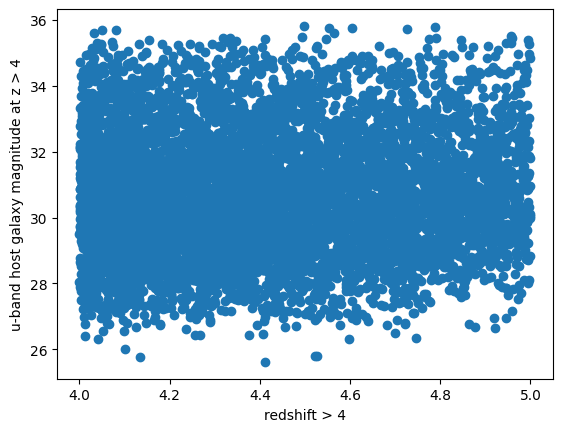

In [10]:
plt.scatter(
    galaxy_simulation_pipeline.red_galaxies[
        galaxy_simulation_pipeline.red_galaxies["z"] > 4
    ]["z"],
    galaxy_simulation_pipeline.red_galaxies[
        galaxy_simulation_pipeline.red_galaxies["z"] > 4
    ]["mag_u"],
)
plt.xlabel("redshift > 4")
plt.ylabel("u-band host galaxy magnitude at z > 4")

### Generate lens galaxy population


In [11]:
lens_galaxies_ell = deflectors.EllipticalLensGalaxies(
    galaxy_list=galaxy_simulation_pipeline.red_galaxies,
    kwargs_cut=kwargs_deflector_cut,
    kwargs_mass2light={},
    cosmo=cosmo,
    sky_area=galaxy_sky_area,
    gamma_pl=dict(mean=2.0, std_dev=0.16),
)

/Users/padmavenkatraman/Documents/StrongLensing/slsim/slsim/Deflectors/DeflectorPopulation/elliptical_lens_galaxies.py:48: UserWarning: Angular size is converted to arcsec because provided input_catalog_type is skypy. If this is not correct, please refer to the documentation of the class you are using
  galaxy_list = param_util.catalog_with_angular_size_in_arcsec(


#### Verify the stellar mass - velocity dispersion relation

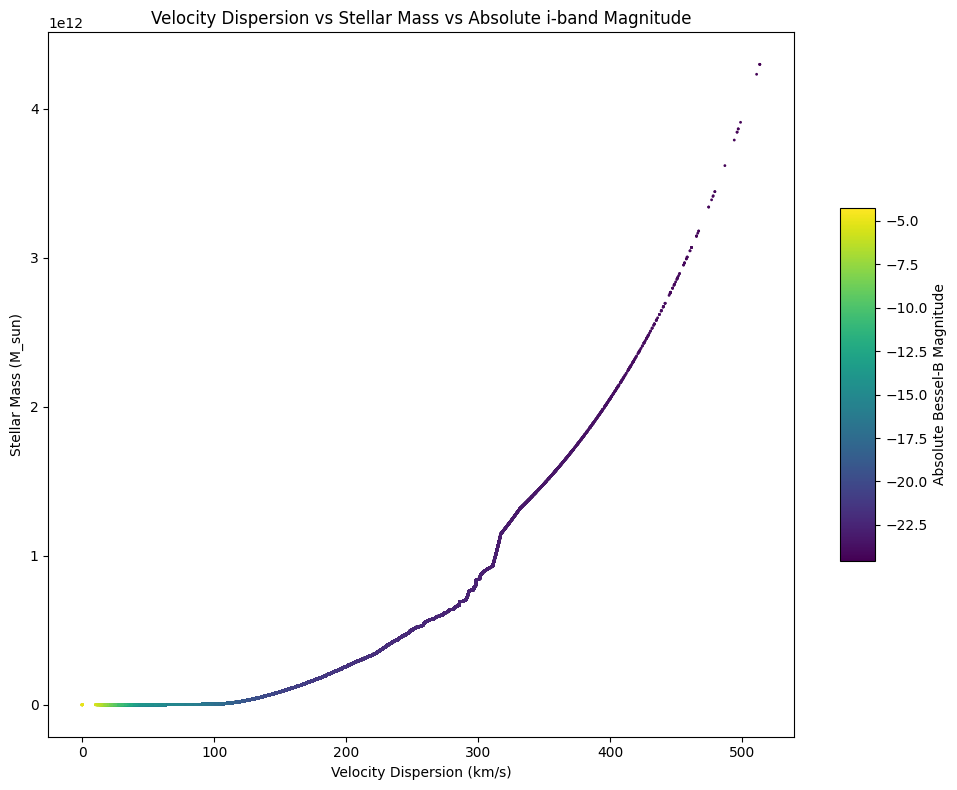

In [12]:
galaxies = [lens_galaxies_ell.draw_deflector() for _ in range(500000)]
velocity_dispersion = [gal.velocity_dispersion() for gal in galaxies]
stellar_mass = [gal.stellar_mass for gal in galaxies]
absolute_i_mag = [gal.absolute_bessel_b_magnitude() for gal in galaxies]
fig, ax = plt.subplots(figsize=(10, 8))
sc = ax.scatter(
    velocity_dispersion, stellar_mass, c=absolute_i_mag, cmap="viridis", s=1
)

ax.set_xlabel("Velocity Dispersion (km/s)")
ax.set_ylabel("Stellar Mass (M_sun)")
ax.set_title("Velocity Dispersion vs Stellar Mass vs Absolute i-band Magnitude")
cbar = plt.colorbar(sc, ax=ax, shrink=0.5, aspect=10)
cbar.set_label("Absolute Bessel-B Magnitude")

plt.tight_layout()
plt.show()

/Users/padmavenkatraman/Documents/StrongLensing/slsim_env/lib/python3.11/site-packages/corner/core.py:846: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if xs[k1] is not None:
/Users/padmavenkatraman/Documents/StrongLensing/slsim_env/lib/python3.11/site-packages/corner/core.py:847: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  axes[k1, k1].axvline(xs[k1], **kwargs)
/Users/padmavenkatraman/Documents/StrongLensing/slsim_env/lib/python3.11/site-packages/corner/core.py:849: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consi

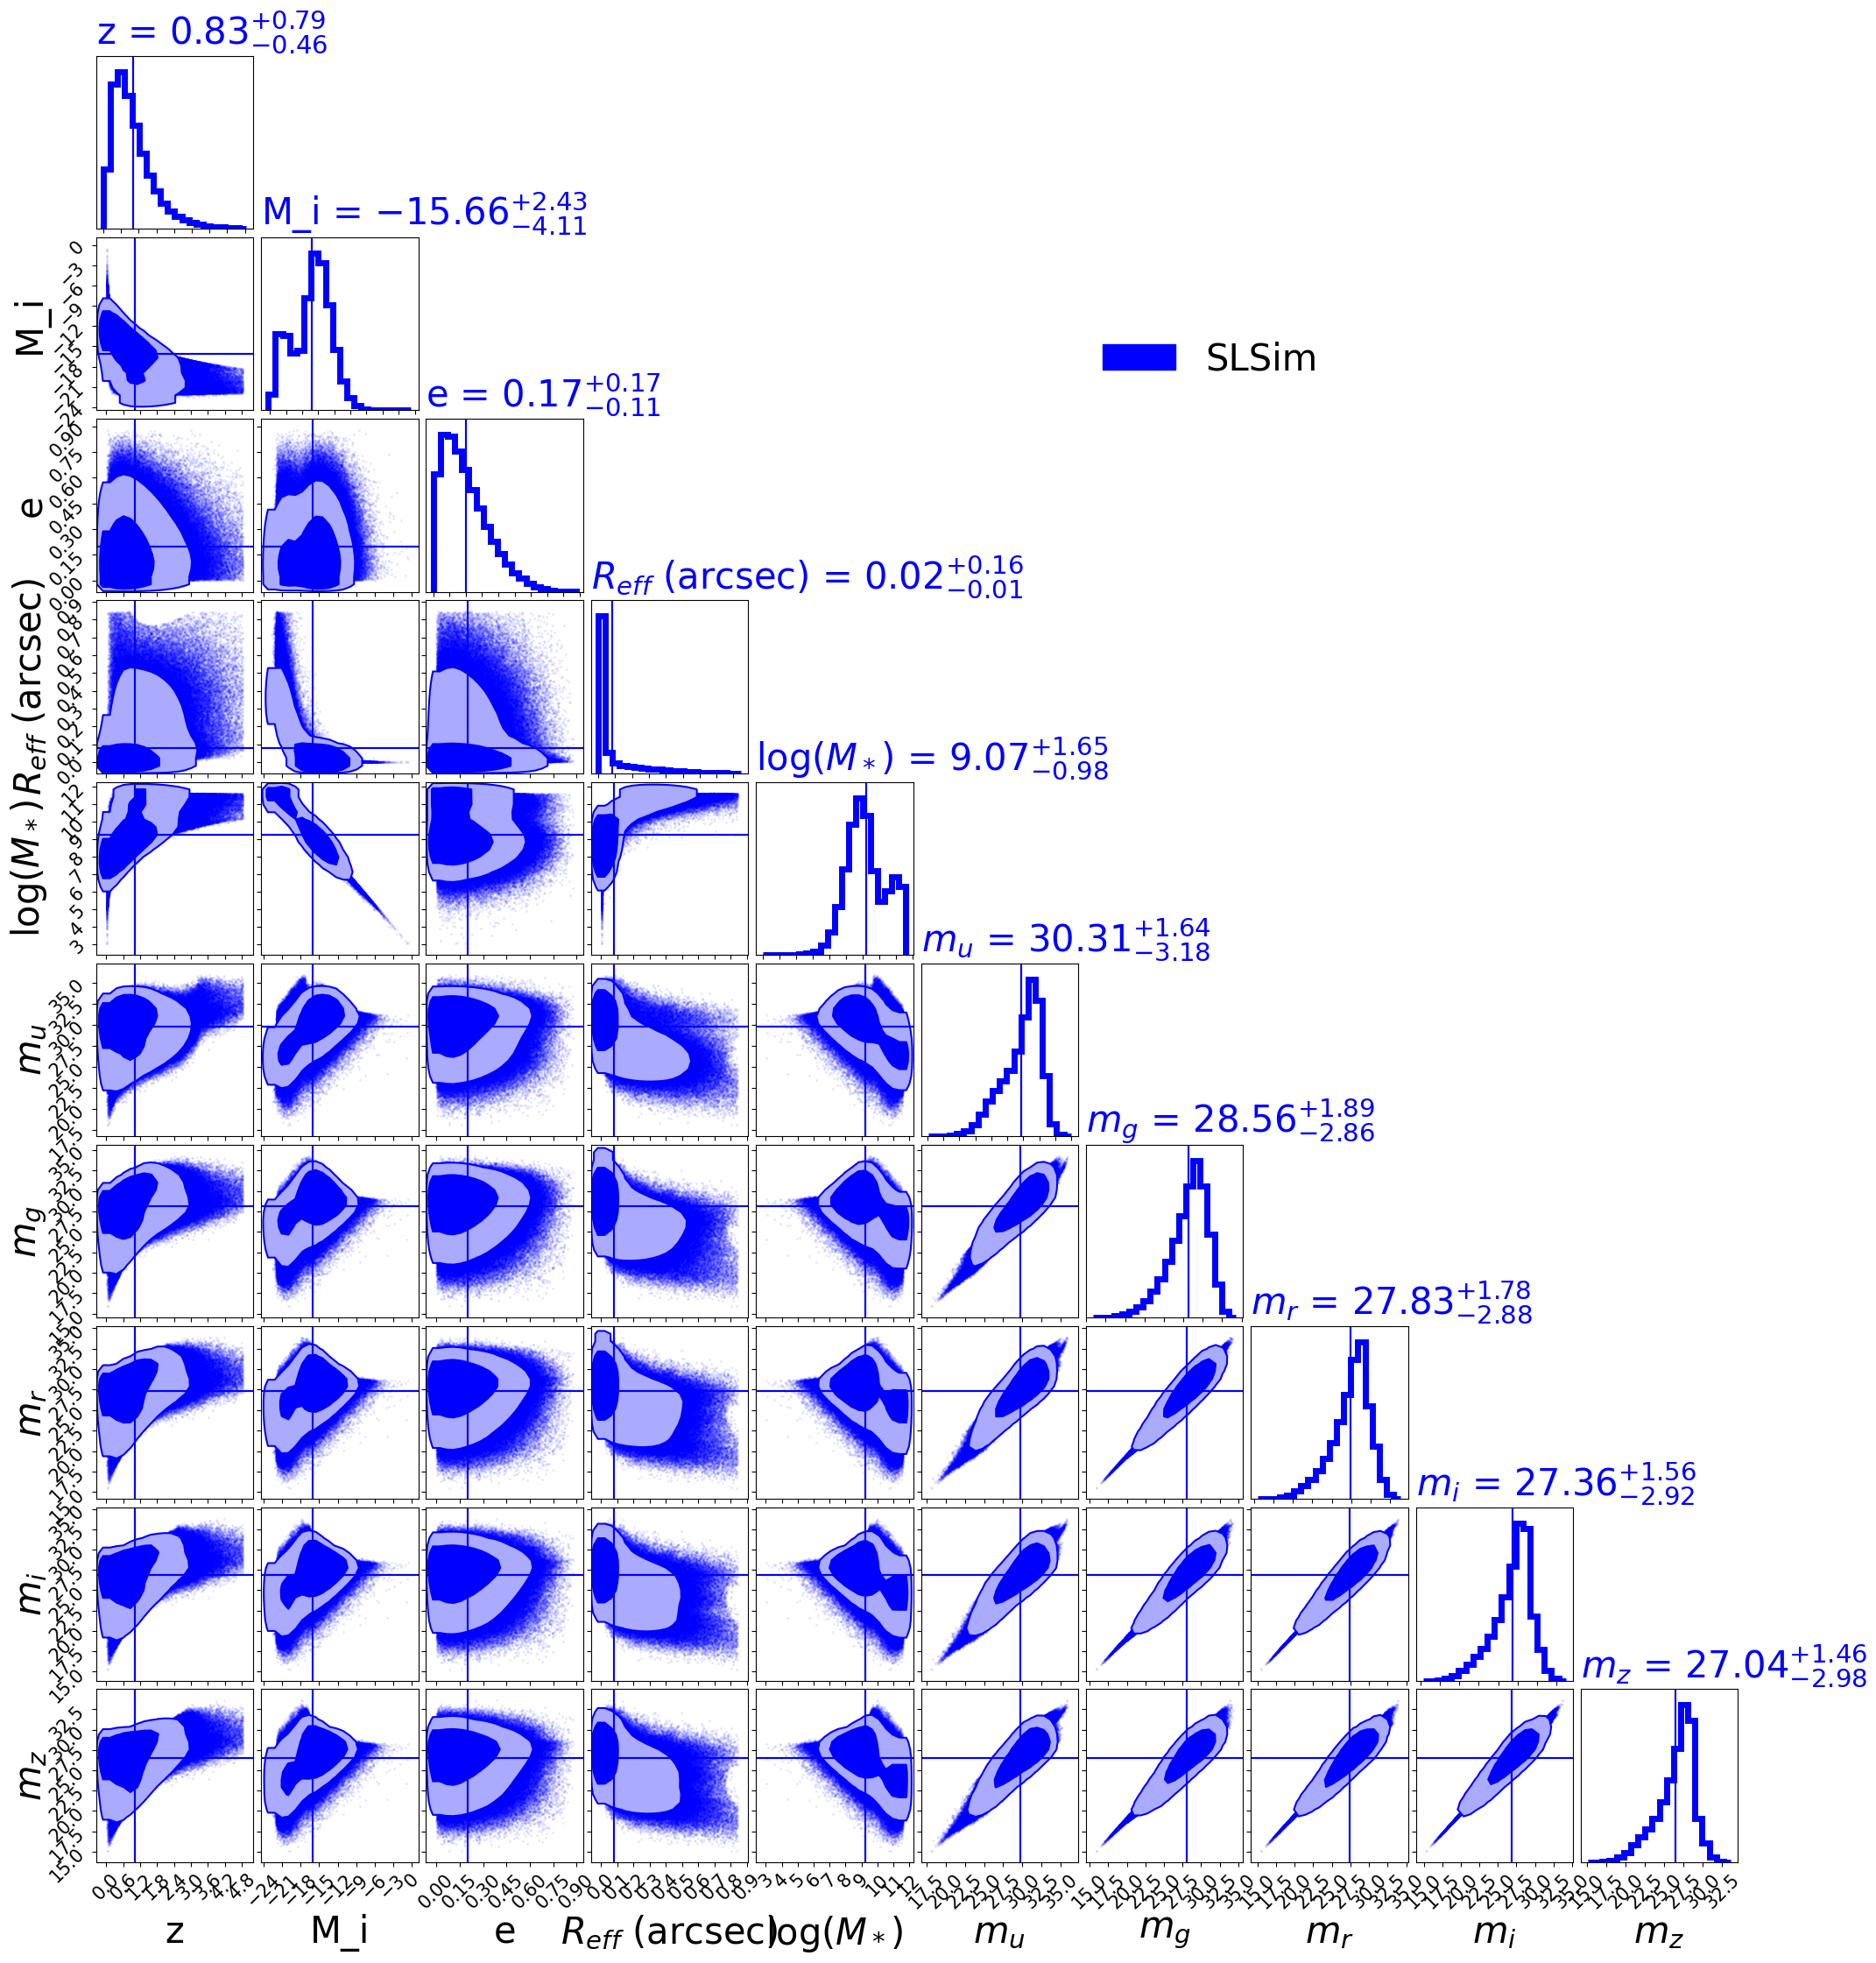

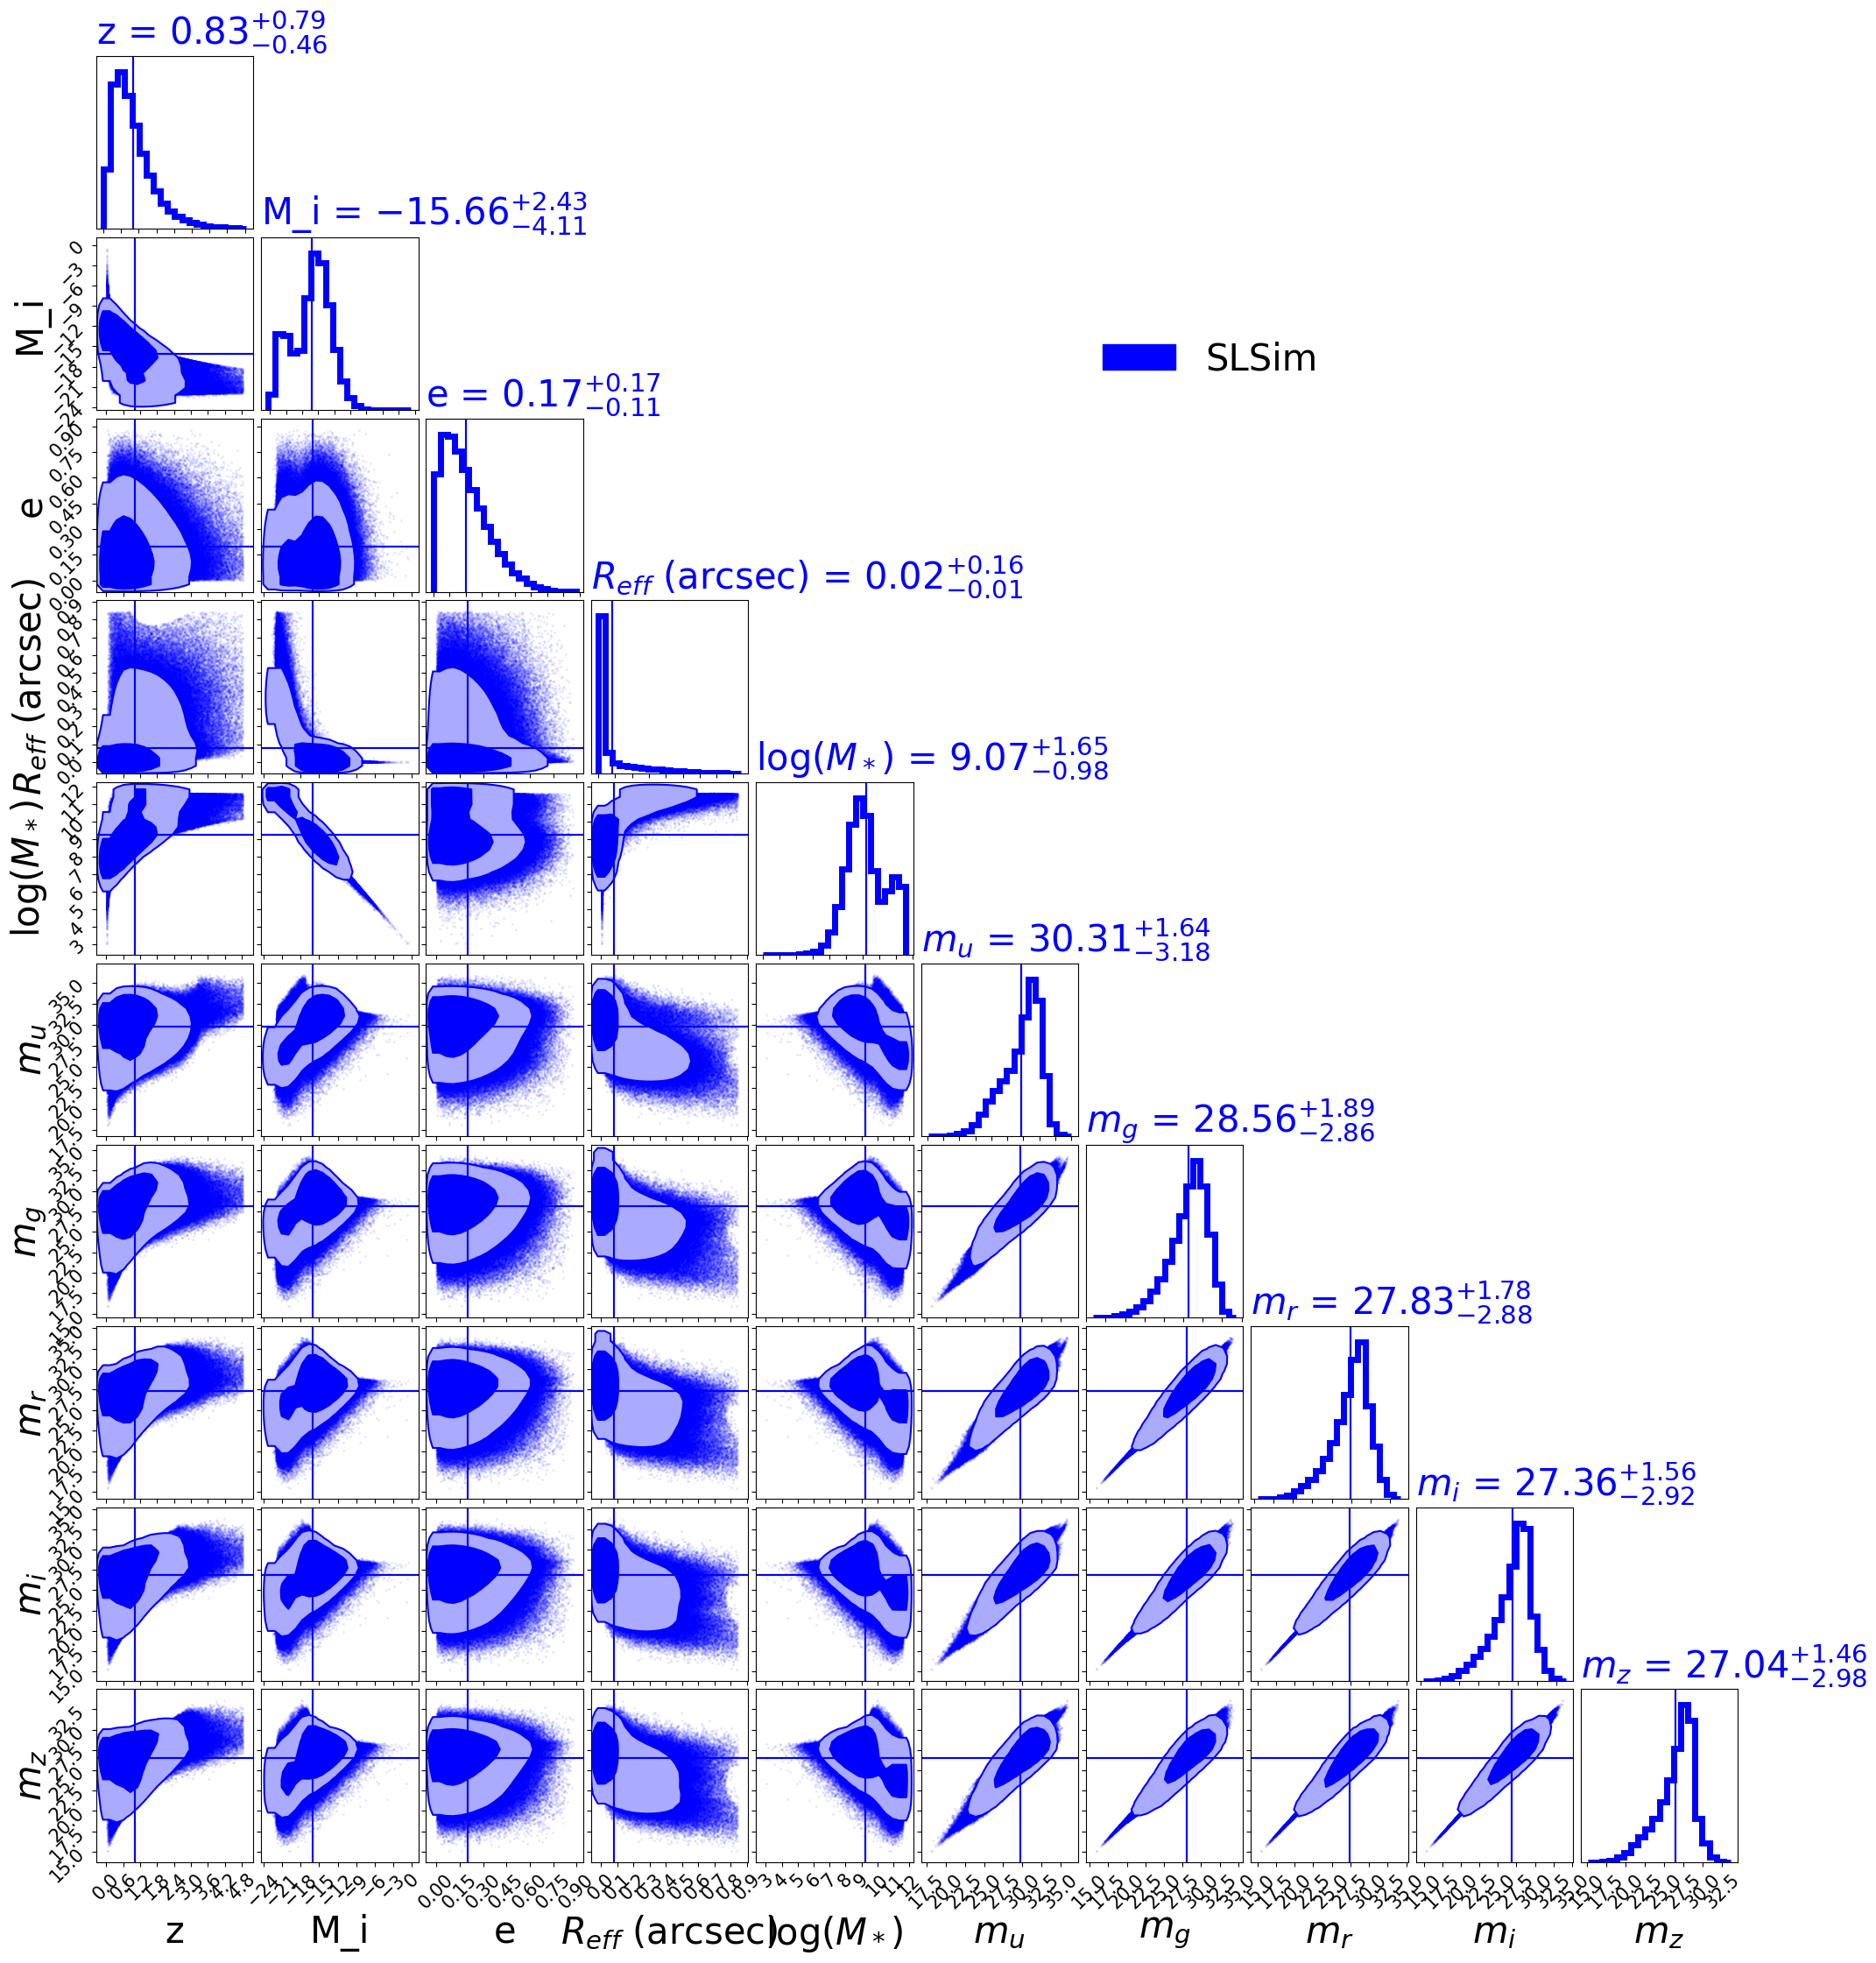

In [ ]:
# Extract the relevant columns and log-transform the specified ones
data = lens_galaxies_ell.deflector_table[
    [
        "z",
        "M",
        "ellipticity",
        "physical_size",
        "angular_size",
        "stellar_mass",
        "mag_u",
        "mag_r",
        "mag_i",
        "mag_z",
        "mag_y",
    ]
].to_pandas()

# Apply log transformation
data["log_physical_size"] = np.log10(data["physical_size"])
data["log_angular_size"] = np.log10(data["angular_size"])
data["log_stellar_mass"] = np.log10(data["stellar_mass"])

# Sigma clip the data
clipped_data = sigma_clip(data, sigma=5, axis=0).filled(np.nan)
new_df = pd.DataFrame(clipped_data, columns=data.columns).dropna()

# Create the contour plot
make_contour(
    list_of_dists=[
        new_df[
            [
                "z",
                "M",
                "ellipticity",
                "angular_size",
                "log_stellar_mass",
                "mag_u",
                "mag_r",
                "mag_i",
                "mag_z",
                "mag_y",
            ]
        ]
    ],
    labels=[
        "z",
        "M_i",
        "e",
        "$R_{eff}$ (arcsec)",
        "log($M_*$)",
        "$m_u$",
        "$m_g$",
        "$m_r$",
        "$m_i$",
        "$m_z$",
        "$m_y$",
    ],
    categories=["SLSim"],
    colors=["blue"],
)

In [13]:
# Initiate QuasarRate class to generate quasar sample.
quasar_class = QuasarRate(
    cosmo=cosmo,
    sky_area=quasar_sky_area,
    noise=True,
    redshifts=np.linspace(0.001, 6.00, 100),  # these redshifts are provided
    # to match general slsim redshift range in skypy pipeline.
)
# quasar sample with host galaxy
quasar_source_plus_galaxy = quasar_class.quasar_sample(
    m_min=15, m_max=28, host_galaxy=True
)

Matching quasars with host galaxies: 100%|██████████| 45466/45466 [00:13<00:00, 3322.98it/s]


In [14]:
# Prepare dictionary of agn variability kwargs
length_of_light_curve = 3850
MACLEOD2010_MEANS = np.array(
    [8.53308079, -23.48721021, -0.51665998, 2.28708691, 2.11640976]
)
MACLEOD2010_COV = np.array(
    [
        [0.27862905, -0.29501766, 0.00675703, 0.04606804, -0.00665875],
        [-0.29501766, 2.06855169, 0.19690851, 0.0244139, -0.29913764],
        [0.00675703, 0.19690851, 0.02785685, 0.01083628, -0.02216221],
        [0.04606804, 0.0244139, 0.01083628, 0.05636087, -0.02716507],
        [-0.00665875, -0.29913764, -0.02216221, -0.02716507, 0.3077278],
    ]
)
#############################################################################


# Prepare dictionary of agn variability kwargs
# Note: the means array and covariance matrix should be defined in following order and units:
# log(BH_mass/Msun), M_i, log(SFi_inf/mag), log(tau/days), zsrc
# variable_agn_kwarg_dict = {
#     "multivariate_gaussian_means": MACLEOD2010_MEANS,
#     "multivariate_gaussian_covs": MACLEOD2010_COV,
#     "known_band": "lsst2016-i",
# }
variable_agn_kwarg_dict = {
    "length_of_light_curve": length_of_light_curve,
    "time_resolution": 1,
    # "log_breakpoint_frequency": 1 / 20,
    # "low_frequency_slope": 1,
    # "high_frequency_slope": 3,
    # "standard_deviation": 0.9,
}
# variable_agn_kwarg_dict = {}
kwargs_quasar = {
    "variability_model": "light_curve",
    "kwargs_variability": {"agn_lightcurve", "u", "g", "r", "i", "z", "y"},
    "agn_driving_variability_model": "bending_power_law_from_distribution",
    "agn_driving_kwargs_variability": variable_agn_kwarg_dict,
    "lightcurve_time": np.linspace(0, length_of_light_curve, length_of_light_curve),
    "corona_height": 10,
    "r_resolution": 500,
}
# Initiate source population class.
source_quasar_plus_galaxies = sources.PointPlusExtendedSources(
    point_plus_extended_sources_list=quasar_source_plus_galaxy,
    cosmo=cosmo,
    sky_area=quasar_sky_area,
    kwargs_cut=kwargs_source_cut,
    list_type="astropy_table",
    catalog_type="skypy",
    point_source_type="quasar",
    extended_source_type="single_sersic",
    point_source_kwargs=kwargs_quasar,
)

In [ ]:
quasar_lens_pop_ell = LensPop(
    deflector_population=lens_galaxies_ell,
    source_population=source_quasar_plus_galaxies,
    cosmo=cosmo,
    sky_area=full_sky_area,
)
kwargs_lens_cuts = {
    "min_image_separation": 0.6,
    "max_image_separation": 10,
    "second_brightest_image_cut": {"i": 24},
}
quasar_lens_population = quasar_lens_pop_ell.draw_population(
    speed_factor=1000, kwargs_lens_cuts=kwargs_lens_cuts
)

Drawing lens population: 100%|██████████| 220103/220103 [00:26<00:00, 8167.54it/s]


### mini img sep and mag lim analysis

In [5]:
# # Initiate LensPop class to generate lensed quasar pop.
# quasar_lens_pop_ell = LensPop(
#     deflector_population=lens_galaxies_ell,
#     source_population=source_quasar_plus_galaxies,
#     cosmo=cosmo,
#     sky_area=full_sky_area,
# )
# qlp_img_sep = {}
# for mag_lim in np.arange(23.3, 24.1, 0.1):
#     for image_sep in np.arange(0.5, 1.1, 0.1):
#     ### LSST cuts: 'u': 23.9,'g':25.0, 'r':24.7, 'i':24.0, 'z':23.3, 'y':22.1
#         kwargs_lens_cuts = {
#             "min_image_separation": image_sep,
#             "max_image_separation": 10,
#             "second_brightest_image_cut": {"i": mag_lim},
#         }
#         qlp = []
#         for i in range(4):
#         # drawing population
#         # the key difference in lens population drawing time is whether you ask for magnitude cuts or not I think?
#             quasar_lens_population = quasar_lens_pop_ell.draw_population(
#                 speed_factor=1000, kwargs_lens_cuts=kwargs_lens_cuts
#             )
#             qlp.extend(quasar_lens_population)
#         qlp_img_sep[f'{image_sep}_{mag_lim}'] = qlp

23.3 0.5 183 0.08054577464788733
23.3 0.6 198 0.09209302325581395
23.3 0.7 153 0.07993730407523511
23.3 0.8 143 0.08157444381061038
23.3 0.9 141 0.08779576587795766
23.3 1.0 128 0.08677966101694916
23.3 1.1 116 0.09098039215686274
----------------
23.4 0.5 207 0.08933966335779024
23.4 0.6 196 0.08900999091734786
23.4 0.7 161 0.08243727598566308
23.4 0.8 143 0.07642971672902191
23.4 0.9 150 0.08797653958944282
23.4 1.0 123 0.08238446081714669
23.4 1.1 133 0.096028880866426
----------------
23.5 0.5 218 0.08562450903377848
23.5 0.6 210 0.08849557522123894
23.5 0.7 184 0.08463661453541858
23.5 0.8 171 0.084070796460177
23.5 0.9 155 0.08630289532293986
23.5 1.0 124 0.07537993920972644
23.5 1.1 140 0.09562841530054644
----------------
23.6 0.5 140 0.053252187143400534
23.6 0.6 200 0.07883326763894363
23.6 0.7 166 0.07674526121128063
23.6 0.8 179 0.08287037037037037
23.6 0.9 148 0.08017334777898158
23.6 1.0 148 0.08409090909090909
23.6 1.1 138 0.09037328094302555
----------------
23.7 0.5 21

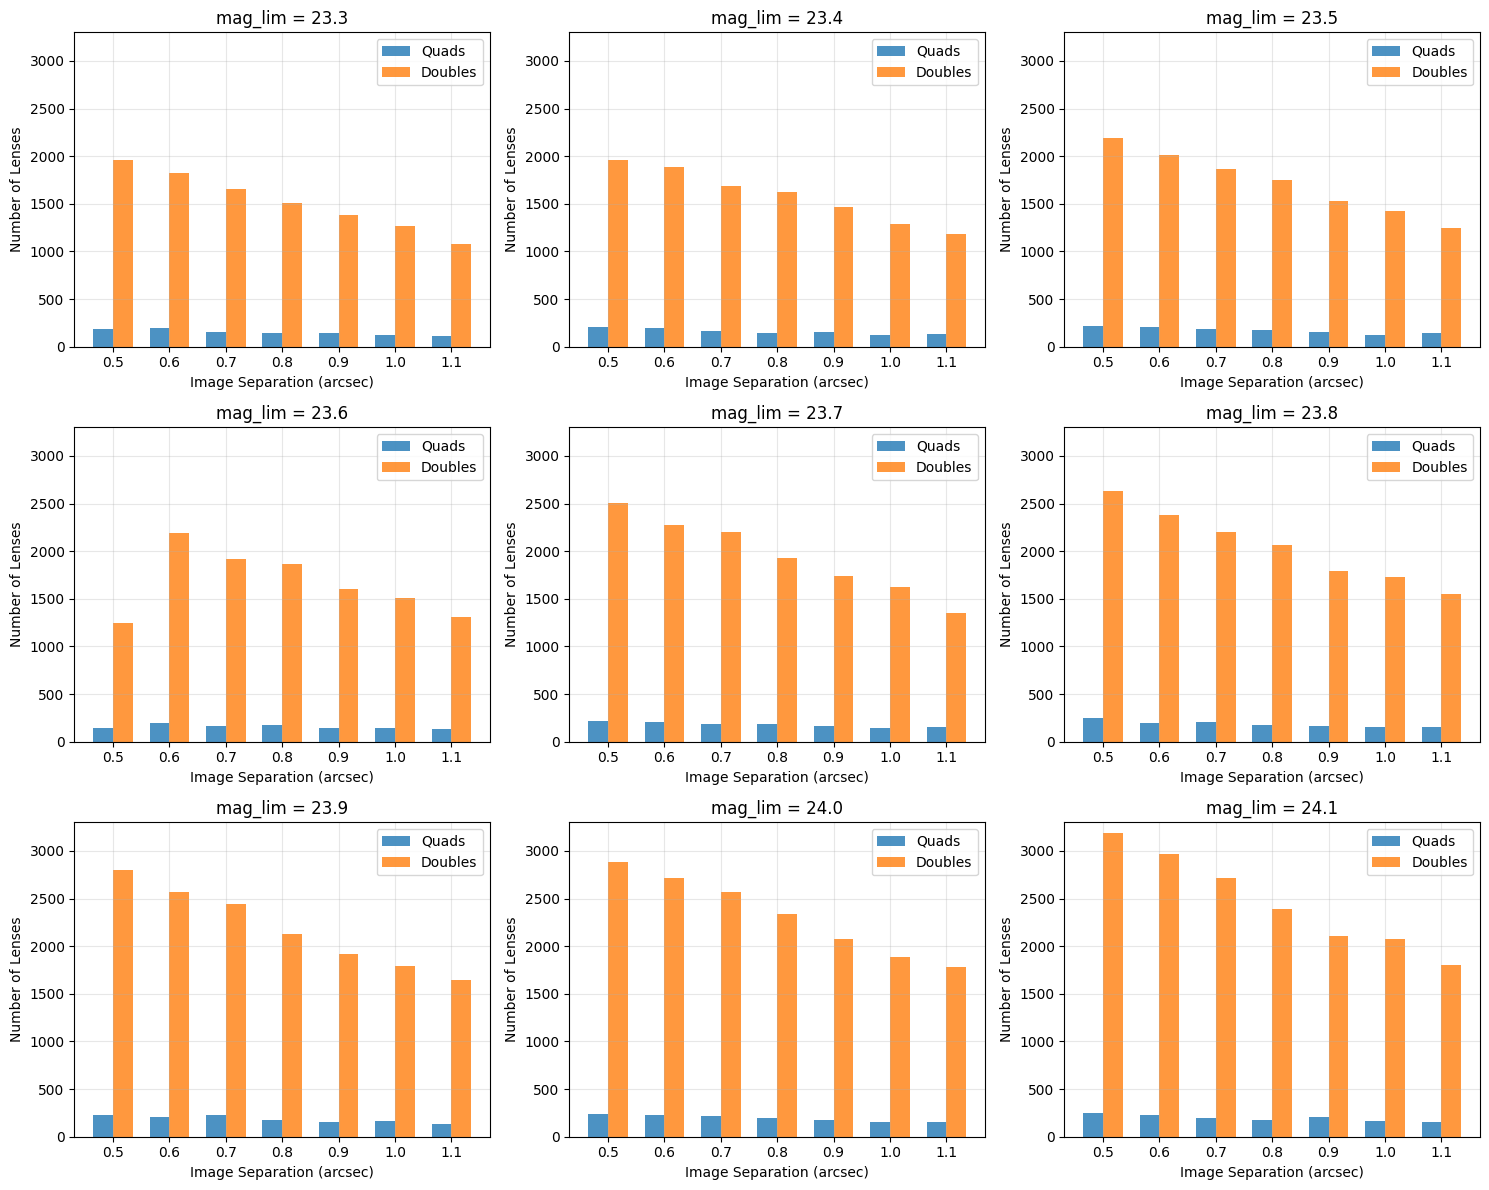

In [ ]:
# import matplotlib.pyplot as plt

# # Extract unique mag_lim values
# mag_lims = sorted(set(float(k.split("_")[1]) for k in qlp_img_sep.keys()))

# # Create a 3x3 subplot grid
# fig, axes = plt.subplots(3, 3, figsize=(15, 12))
# axes = axes.flatten()

# # Plot for each mag_lim
# for idx, mag_lim in enumerate(mag_lims):
#     ax = axes[idx]
#     ax.set_ylim(0, 3300)
#     # Extract image separations and counts for this mag_lim
#     image_seps = []
#     counts = []

#     for k in qlp_img_sep.keys():

#         if np.round(float(k.split("_")[1]), 1) == np.round(mag_lim, 1):
#             img_sep = np.round(float(k.split("_")[0]), 1)
#             try:
#                 num_images = [
#                     qlp_img_sep[k][i].image_number[0]
#                     for i in range(len(qlp_img_sep[k]))
#                 ]
#             except IndexError:
#                 print(qlp_img_sep[k][i])
#             num_quads = sum(1 for n in num_images if n == 4)
#             num_doubles = sum(1 for n in num_images if n == 2)
#             print(
#                 np.round(mag_lim, 1),
#                 img_sep,
#                 num_quads,
#                 num_quads / (len(qlp_img_sep[k])),
#             )
#             image_seps.append(img_sep)
#             counts.append([num_quads, num_doubles])
#     print("----------------")
#     # Sort by image separation
#     sorted_pairs = sorted(zip(image_seps, counts))
#     image_seps, counts = zip(*sorted_pairs) if sorted_pairs else ([], [])

#     counts_array = np.array(counts)
#     x = np.arange(len(image_seps))
#     width = 0.35

#     ax.bar(x - width / 2, counts_array[:, 0], width, label="Quads", alpha=0.8)
#     ax.bar(x + width / 2, counts_array[:, 1], width, label="Doubles", alpha=0.8)
#     ax.set_xticks(x)
#     ax.set_xticklabels([f"{sep:.1f}" for sep in image_seps])
#     ax.legend()
#     ax.set_xlabel("Image Separation (arcsec)", fontsize=10)
#     ax.set_ylabel("Number of Lenses", fontsize=10)
#     ax.set_title(f"mag_lim = {mag_lim:.1f}", fontsize=12)
#     ax.grid(True, alpha=0.3)

# plt.tight_layout()
# plt.show()

#### So far we've looked at how different populations can be generated for different image separations/magnitude limits
Now we pick a one image separation (0.5), magnitude limits (24) and go on to simulate the whole population -- 7% quads

In [38]:
f = io.StringIO()
full_pop_df = pd.DataFrame()
with redirect_stdout(f):
    for i, lens_obj in enumerate(quasar_lens_population):
        full_pop_df = lens_obj.lens_to_dataframe(index=i, df=full_pop_df)
        image2mag = full_pop_df.loc[i, "point_source_light_i_magnitude_1"]
        try:
            image3mag = full_pop_df.loc[i, "point_source_light_i_magnitude_2"]
        except KeyError:
            image3mag = 0
        second_or_third_mag = (
            image3mag if not (np.isnan(image3mag) or image3mag == 0) else image2mag
        )
        full_pop_df.loc[i, "i3"] = second_or_third_mag
        (
            full_pop_df.loc[i, "deflector_mass_phi"],
            full_pop_df.loc[i, "deflector_mass_q"],
        ) = ellipticity2phi_q(
            full_pop_df.loc[i, "deflector_mass_e1"],
            full_pop_df.loc[i, "deflector_mass_e2"],
        )
        (
            full_pop_df.loc[i, "deflector_light_phi"],
            full_pop_df.loc[i, "deflector_light_q"],
        ) = ellipticity2phi_q(
            full_pop_df.loc[i, "deflector_light_i_e1"],
            full_pop_df.loc[i, "deflector_light_i_e2"],
        )
        full_pop_df.loc[i, "deflector_stellar_mass"] = lens_obj.deflector_stellar_mass()
        full_pop_df.loc[i, "lens_obj"] = lens_obj

/Users/padmavenkatraman/Documents/StrongLensing/slsim/slsim/Sources/SourceTypes/quasar.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  variability_model="light_curve",
/Users/padmavenkatraman/Documents/StrongLensing/slsim/slsim/Sources/SourceTypes/quasar.py:28: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  random_seed=None,
/Users/padmavenkatraman/Documents/StrongLensing/slsim/slsim/Sources/SourceTypes/quasar.py:29: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value 

In [39]:
for i in full_pop_df.index:
    lens_obj = full_pop_df.loc[i, "lens_obj"]
    for band in list("ugrizy"):
        abs_mag = quasar_class.convert_magnitude(
            full_pop_df.loc[i, f"ps_{band}_mag_true"],
            full_pop_df.loc[i, "point_source_redshift"],
            conversion="apparent_to_absolute",
        )
        full_pop_df.loc[i, f"M_{band}"] = abs_mag
        if np.isnan(abs_mag):
            if band == "y":
                full_pop_df.drop(index=i, inplace=True)

/var/folders/97/kgg891cd1tg6h957n9nm8rkm0000gn/T/ipykernel_44729/1387312917.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  full_pop_df.loc[i, f"M_{band}"] = abs_mag
/var/folders/97/kgg891cd1tg6h957n9nm8rkm0000gn/T/ipykernel_44729/1387312917.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  full_pop_df.loc[i, f"M_{band}"] = abs_mag
/var/folders/97/kgg891cd1tg6h957n9nm8rkm0000gn/T/ipykernel_44729/1387312917.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many t

### Applying a color offset to SLSim quasars

In [40]:
slsim_cols = [
    "point_source_redshift",
    "M_i",
    "ps_u_mag_true",
    "ps_g_mag_true",
    "ps_r_mag_true",
    "ps_i_mag_true",
    "ps_z_mag_true",
    "ps_y_mag_true",
]
slsim_colors = (
    pd.DataFrame(
        {
            "redshift": full_pop_df["point_source_redshift"],
            "i_mag": full_pop_df["M_i"],
            "u-g": full_pop_df["ps_u_mag_true"] - full_pop_df["ps_g_mag_true"],
            "g-r": full_pop_df["ps_g_mag_true"] - full_pop_df["ps_r_mag_true"],
            "r-i": full_pop_df["ps_r_mag_true"] - full_pop_df["ps_i_mag_true"],
            "i-z": full_pop_df["ps_i_mag_true"] - full_pop_df["ps_z_mag_true"],
            "z-y": full_pop_df["ps_z_mag_true"] - full_pop_df["ps_y_mag_true"],
        }
    )
    # .dropna()
    .astype(np.float64)
)

In [41]:
agile_quasars = pd.read_csv("MainNotebooks/agile_quasars.csv", index_col=0)
agile_colors = (
    pd.DataFrame(
        {
            "redshift": agile_quasars["z"],
            "i_mag": agile_quasars["M_i"],
            "u-g": agile_quasars["ps_mag_u"] - agile_quasars["ps_mag_g"],
            "g-r": agile_quasars["ps_mag_g"] - agile_quasars["ps_mag_r"],
            "r-i": agile_quasars["ps_mag_r"] - agile_quasars["ps_mag_i"],
            "i-z": agile_quasars["ps_mag_i"] - agile_quasars["ps_mag_z"],
            "z-y": agile_quasars["ps_mag_z"] - agile_quasars["ps_mag_y"],
        }
    )
    .dropna()
    .astype(np.float64)
)
color_samples = np.array(agile_colors).astype(np.float64)

/Users/padmavenkatraman/Documents/StrongLensing/slsim_env/lib/python3.11/site-packages/corner/core.py:846: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if xs[k1] is not None:
/Users/padmavenkatraman/Documents/StrongLensing/slsim_env/lib/python3.11/site-packages/corner/core.py:847: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  axes[k1, k1].axvline(xs[k1], **kwargs)
/Users/padmavenkatraman/Documents/StrongLensing/slsim_env/lib/python3.11/site-packages/corner/core.py:849: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consi

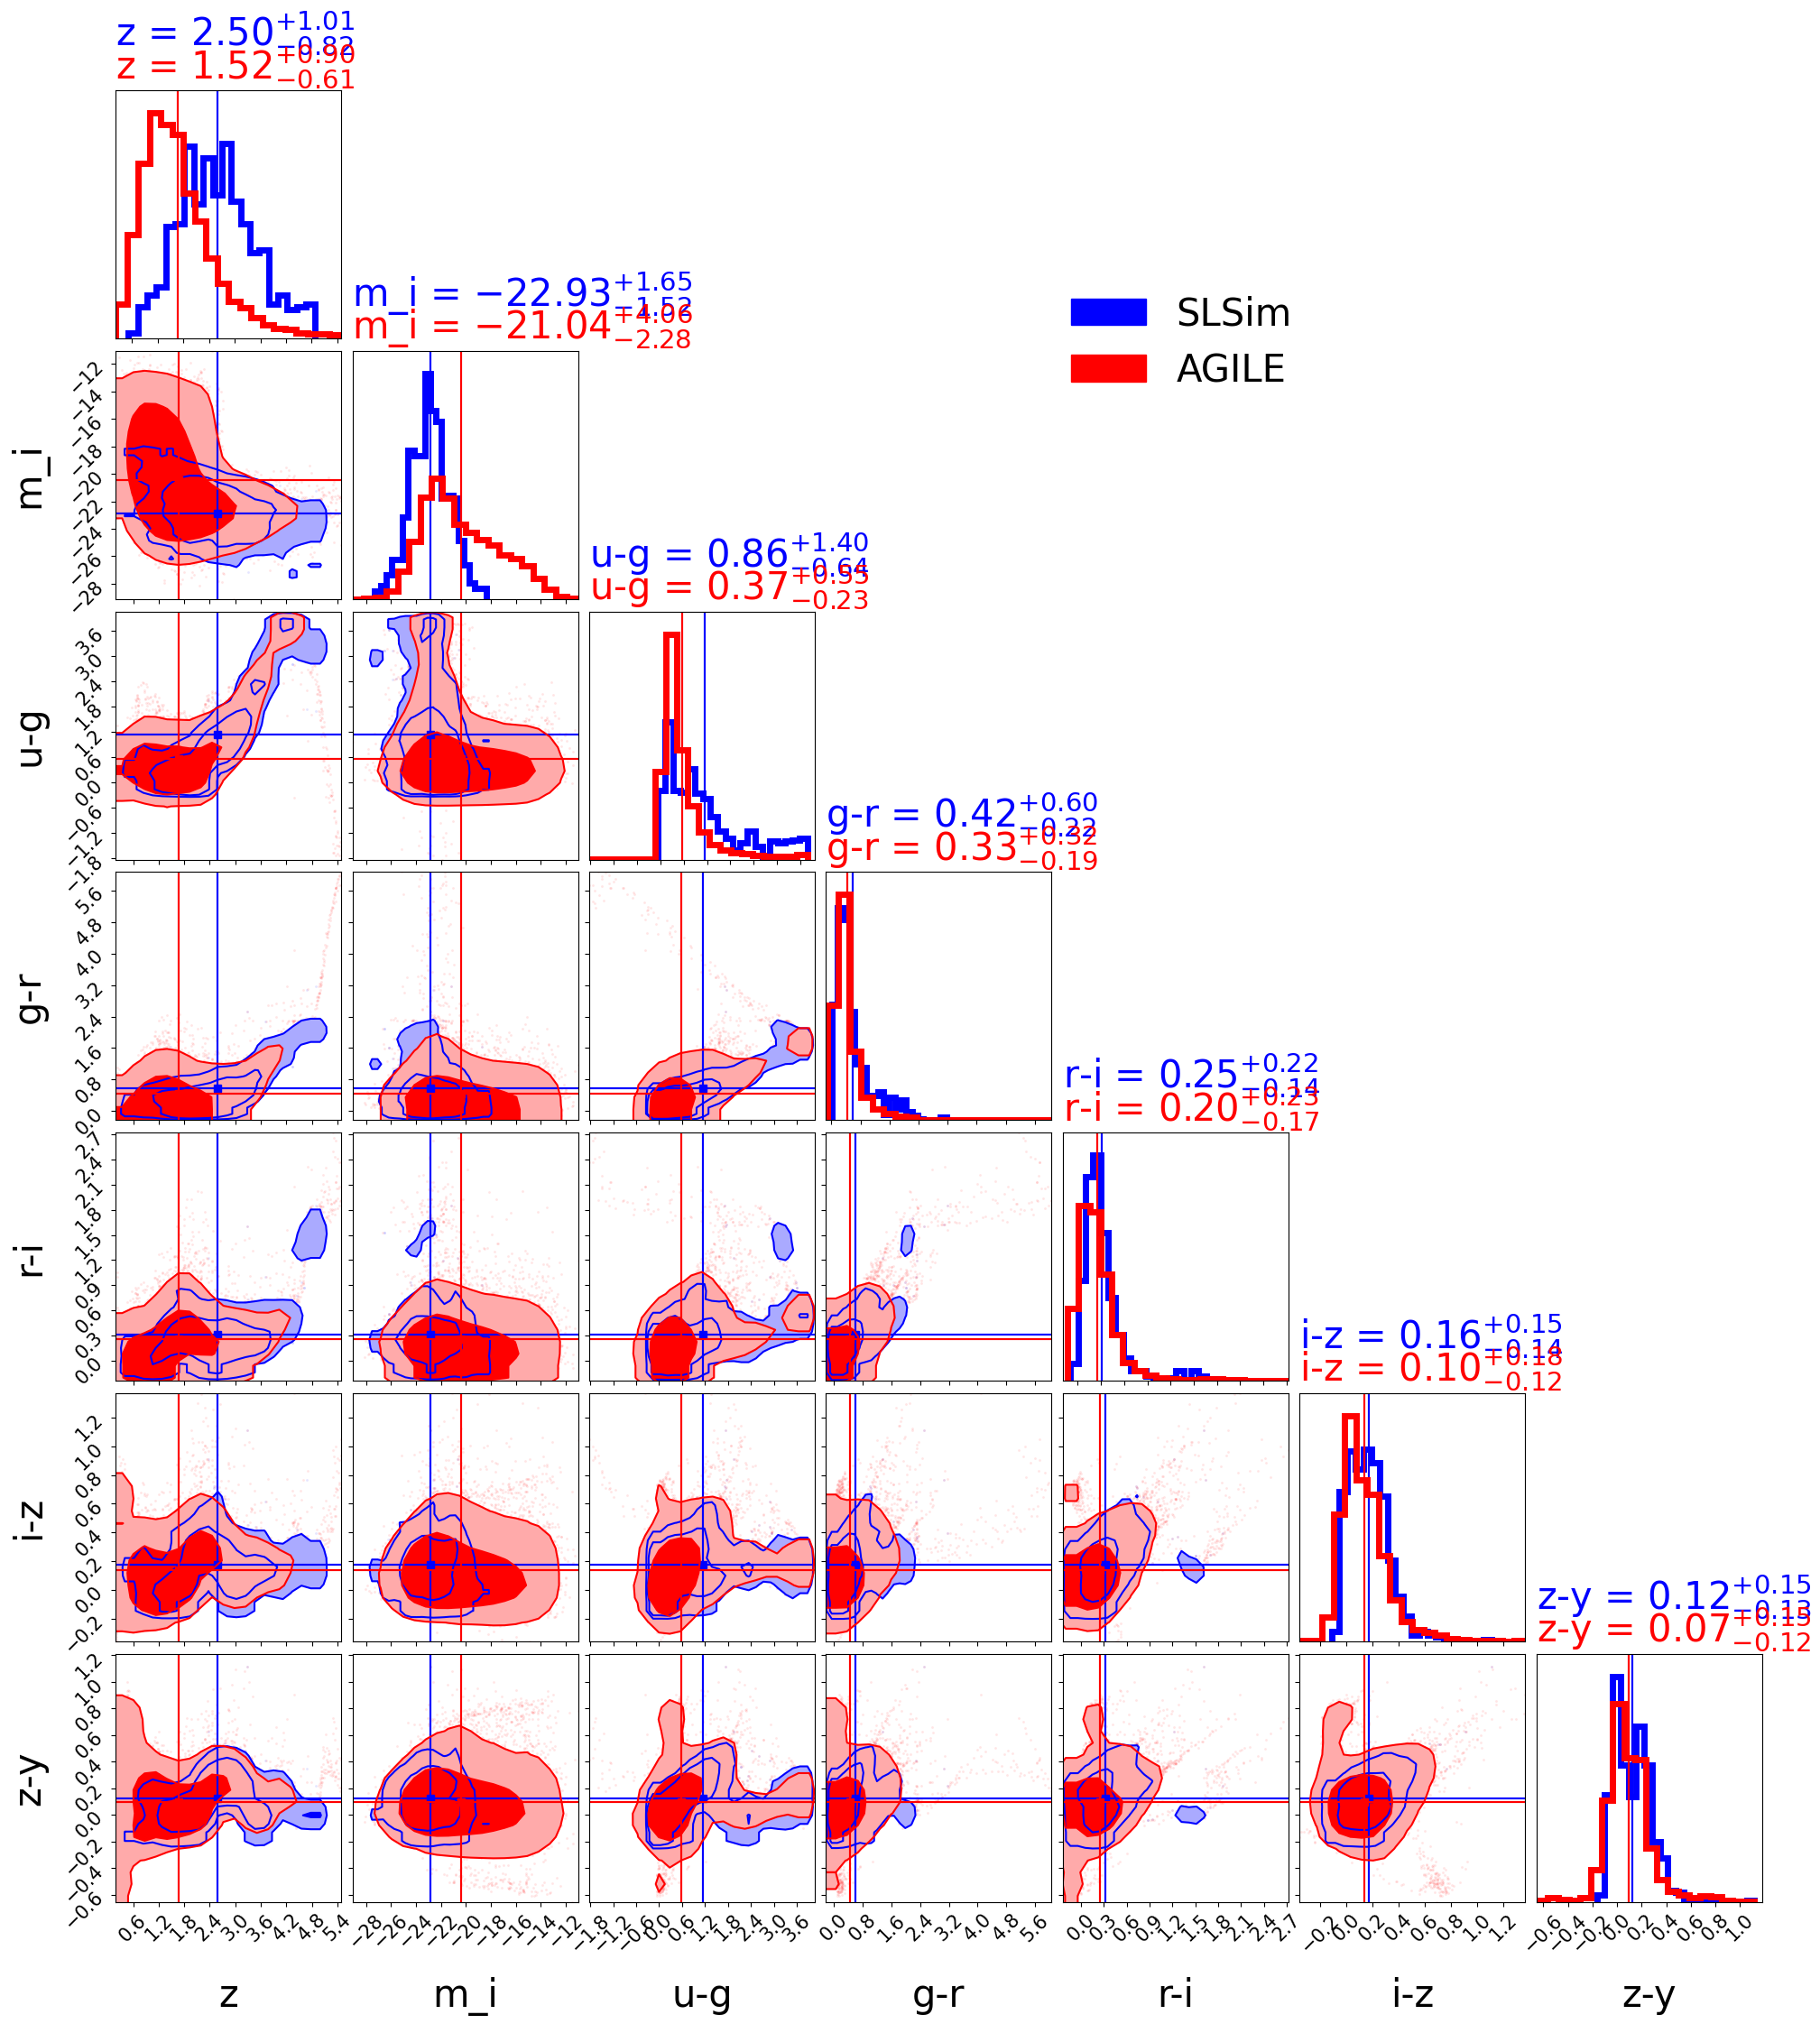

In [43]:
fig = make_contour(
    [slsim_colors, color_samples],
    categories=["SLSim", "AGILE"],
    labels=["z", "m_i", "u-g", "g-r", "r-i", "i-z", "z-y"],
    colors=["blue", "red"],
    show_every_title=True,
);

In [137]:
computed_offsets = []
full_pop_df2 = full_pop_df.copy(deep=True)
for df_ind in tqdm(slsim_colors.index):
    df_row = slsim_colors.loc[df_ind]
    sum_of_squared_differences = np.sum(
        (np.array(df_row[:2]) - color_samples[:, :2]) ** 2, axis=1
    )
    min_dist_ind = np.argmin(
        np.sqrt(np.array(sum_of_squared_differences, dtype="float"))
    )
    selected_sample = color_samples[min_dist_ind]
    computed_offsets.append(selected_sample)

computed_offsets = np.array(computed_offsets)

100%|██████████| 3310/3310 [00:00<00:00, 11036.05it/s]


In [140]:
# slsim_color_with_offset = pd.DataFrame()
# computed offset: u-g, g-r, r-i, i-z, z-y
# u-g = x; u = g + x
# g-r = x; g = r + x
# r-i = x; r = x + i
# i-z = x; z = i - x
# z-y = x; y = z - x
full_pop_df2["ps_r_mag_true"] = full_pop_df2["ps_i_mag_true"] + computed_offsets[:, 4]
full_pop_df2["ps_g_mag_true"] = full_pop_df2["ps_r_mag_true"] + computed_offsets[:, 3]
full_pop_df2["ps_u_mag_true"] = full_pop_df2["ps_g_mag_true"] + computed_offsets[:, 2]
full_pop_df2["ps_z_mag_true"] = full_pop_df2["ps_i_mag_true"] - computed_offsets[:, 5]
full_pop_df2["ps_y_mag_true"] = full_pop_df2["ps_z_mag_true"] - computed_offsets[:, 6]

In [141]:
agile_quasars

z        M_i   ps_mag_u   ps_mag_g   ps_mag_r   ps_mag_i  \
0      1.053878 -23.984892  20.344694  20.100516  19.748081  19.734139   
1      2.371892 -20.568636  26.578406  25.746231  25.527724  25.319815   
2      0.884379 -13.286122  30.243804  29.914233  29.782923  29.861582   
3      2.572131 -23.260589  23.600021  22.876704  22.594465  22.544285   
4      0.591642 -15.663897  27.095985  26.723100  26.719881  26.546555   
...         ...        ...        ...        ...        ...        ...   
14685  3.532532 -22.492523  28.089263  25.679627  24.661555  24.376818   
14686  0.731105 -14.642558  29.124985  28.512923  28.313350  28.287535   
14687  3.516479 -22.299649  28.628480  26.166197  25.123918  24.804485   
14688  1.574680 -22.925434  21.813418  21.629315  21.516275  21.329251   
14689  1.441536 -20.813824  24.528234  24.335965  23.851746  23.643613   

        ps_mag_z   ps_mag_y  
0      19.697694  19.535700  
1      25.037707  24.784901  
2      29.765544  29.710966  
3      22.322031  22.158822  
4      26.698477  26.407663  
...          ...        ...  
14685  24.199573  24.167304  
14686  28.032810  28.248308  
14687  24.599311  24.540039  
14688  21.354862  21.427554  
14689  23.581387  23.612201  

[14690 rows x 8 columns]

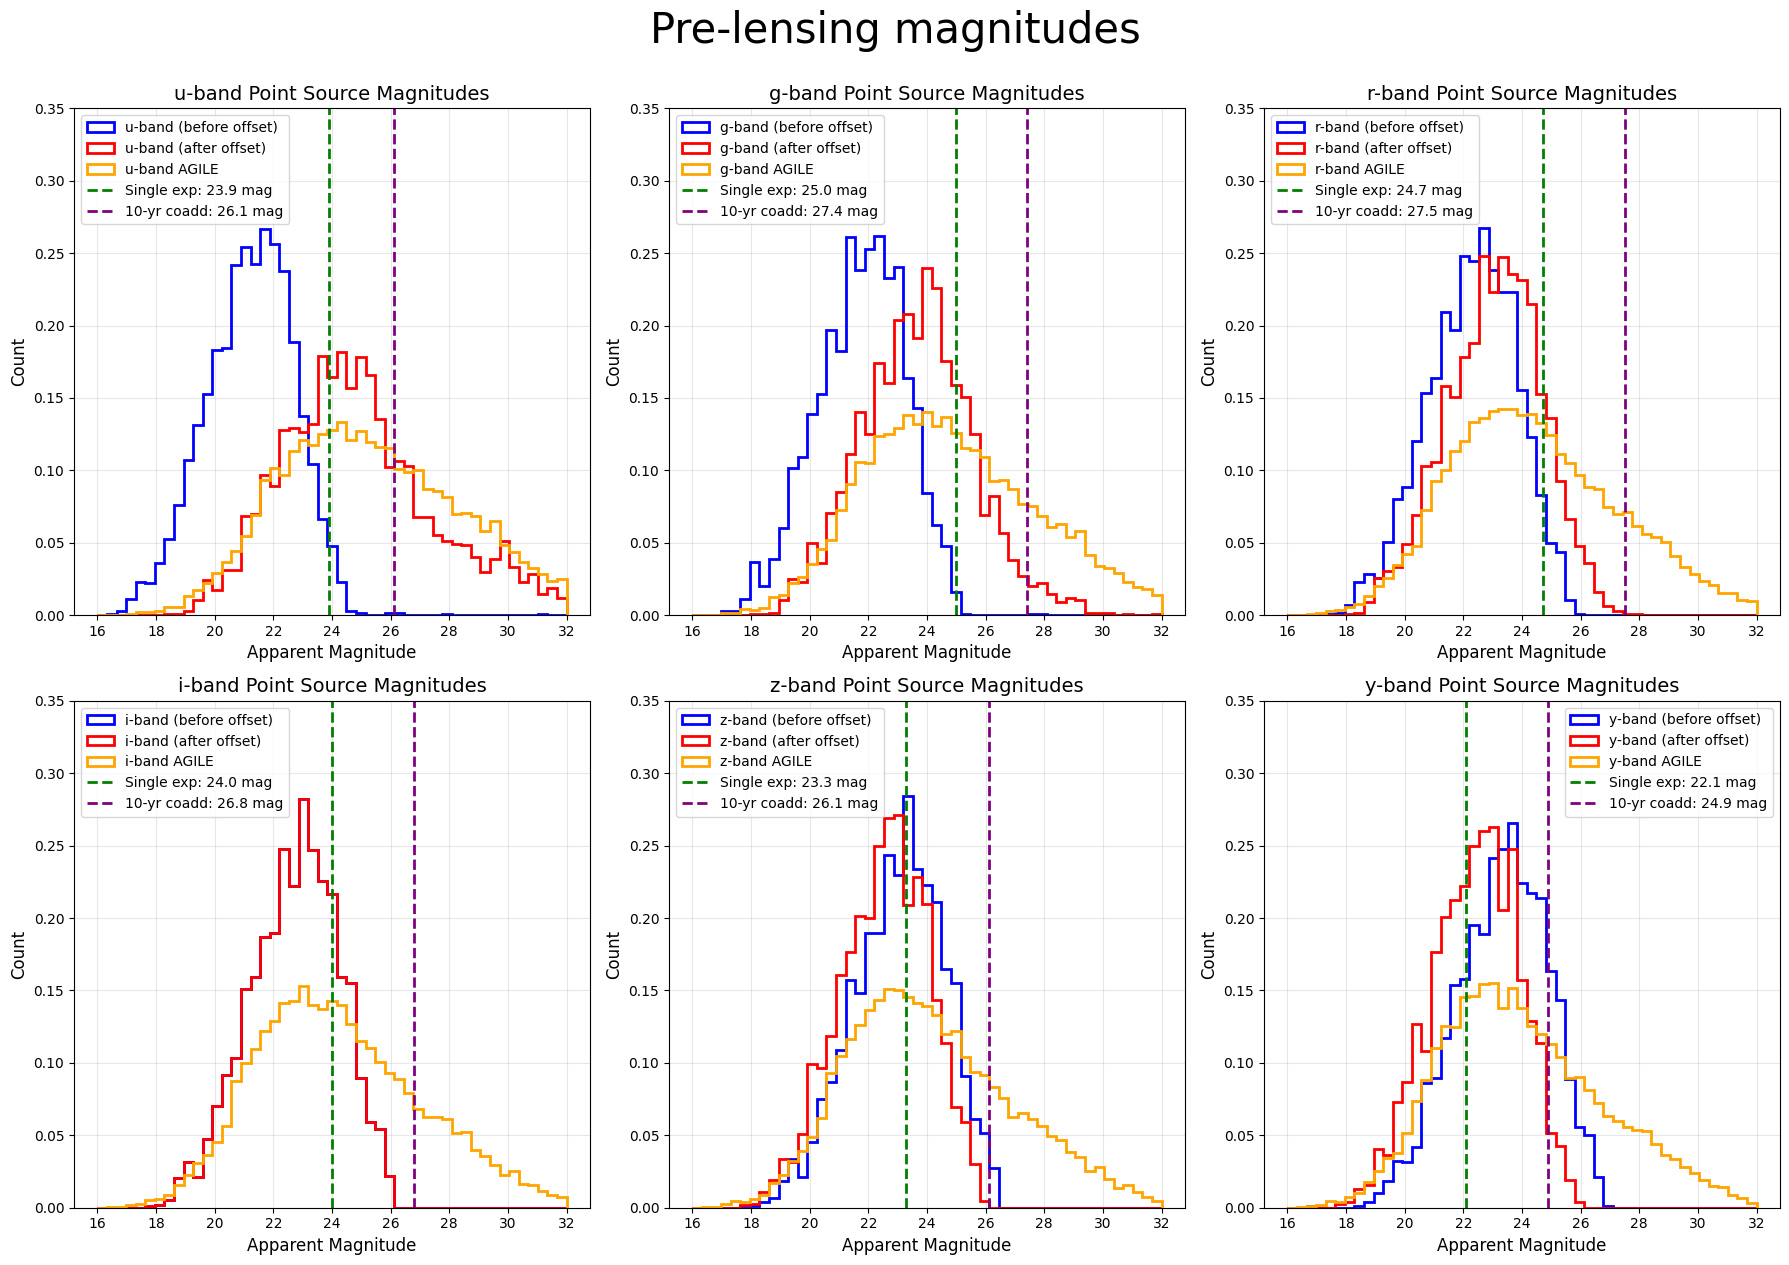

In [144]:
# Create a figure with 6 subplots for magnitude histograms
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

bands = list("ugrizy")
# 5-sigma depth for single exposure and 10-year coadd
depth_limits = {
    "u": (23.9, 26.1),
    "g": (25.0, 27.4),
    "r": (24.7, 27.5),
    "i": (24.0, 26.8),
    "z": (23.3, 26.1),
    "y": (22.1, 24.9),
}

for idx, band in enumerate(bands):
    ax = axes[idx]

    # Define bins for the histogram
    bins = np.linspace(16, 32, 50)

    # Plot histograms for both dataframes
    ax.hist(
        full_pop_df[f"ps_{band}_mag_true"],
        bins=bins,
        density=True,
        histtype="step",
        label=f"{band}-band (before offset)",
        color="blue",
        linewidth=2,
    )
    ax.hist(
        full_pop_df2[f"ps_{band}_mag_true"],
        bins=bins,
        histtype="step",
        label=f"{band}-band (after offset)",
        color="red",
        density=True,
        linewidth=2,
    )
    ax.hist(
        agile_quasars[f"ps_mag_{band}"],
        bins=bins,
        histtype="step",
        label=f"{band}-band AGILE",
        color="orange",
        density=True,
        linewidth=2,
    )

    # Add vertical lines for depth limits
    single_exp_depth, coadd_depth = depth_limits[band]
    ax.axvline(
        single_exp_depth,
        color="green",
        linestyle="--",
        linewidth=2,
        label=f"Single exp: {single_exp_depth} mag",
    )
    ax.axvline(
        coadd_depth,
        color="purple",
        linestyle="--",
        linewidth=2,
        label=f"10-yr coadd: {coadd_depth} mag",
    )

    ax.set_xlabel("Apparent Magnitude", fontsize=12)
    ax.set_ylabel("Count", fontsize=12)
    ax.set_title(f"{band}-band Point Source Magnitudes", fontsize=14)
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)
    ax.set_ylim(0, 0.35)

plt.tight_layout()
fig.suptitle("Pre-lensing magnitudes", y=1.05, size=30)
plt.show()

In [155]:
full_pop_df.loc[0, "ps_r_mag_true"], full_pop_df2.loc[0, "ps_r_mag_true"]

(np.float64(23.26713748162951), np.float64(23.895661825805647))

In [ ]:
# qlp_final[0].point_source_magnitude(band="r", lensed=False)

[np.float64(23.26713748162951)]

### After applying color offsets, take a look at the sample properties:

#### Quasar magnitudes+colors

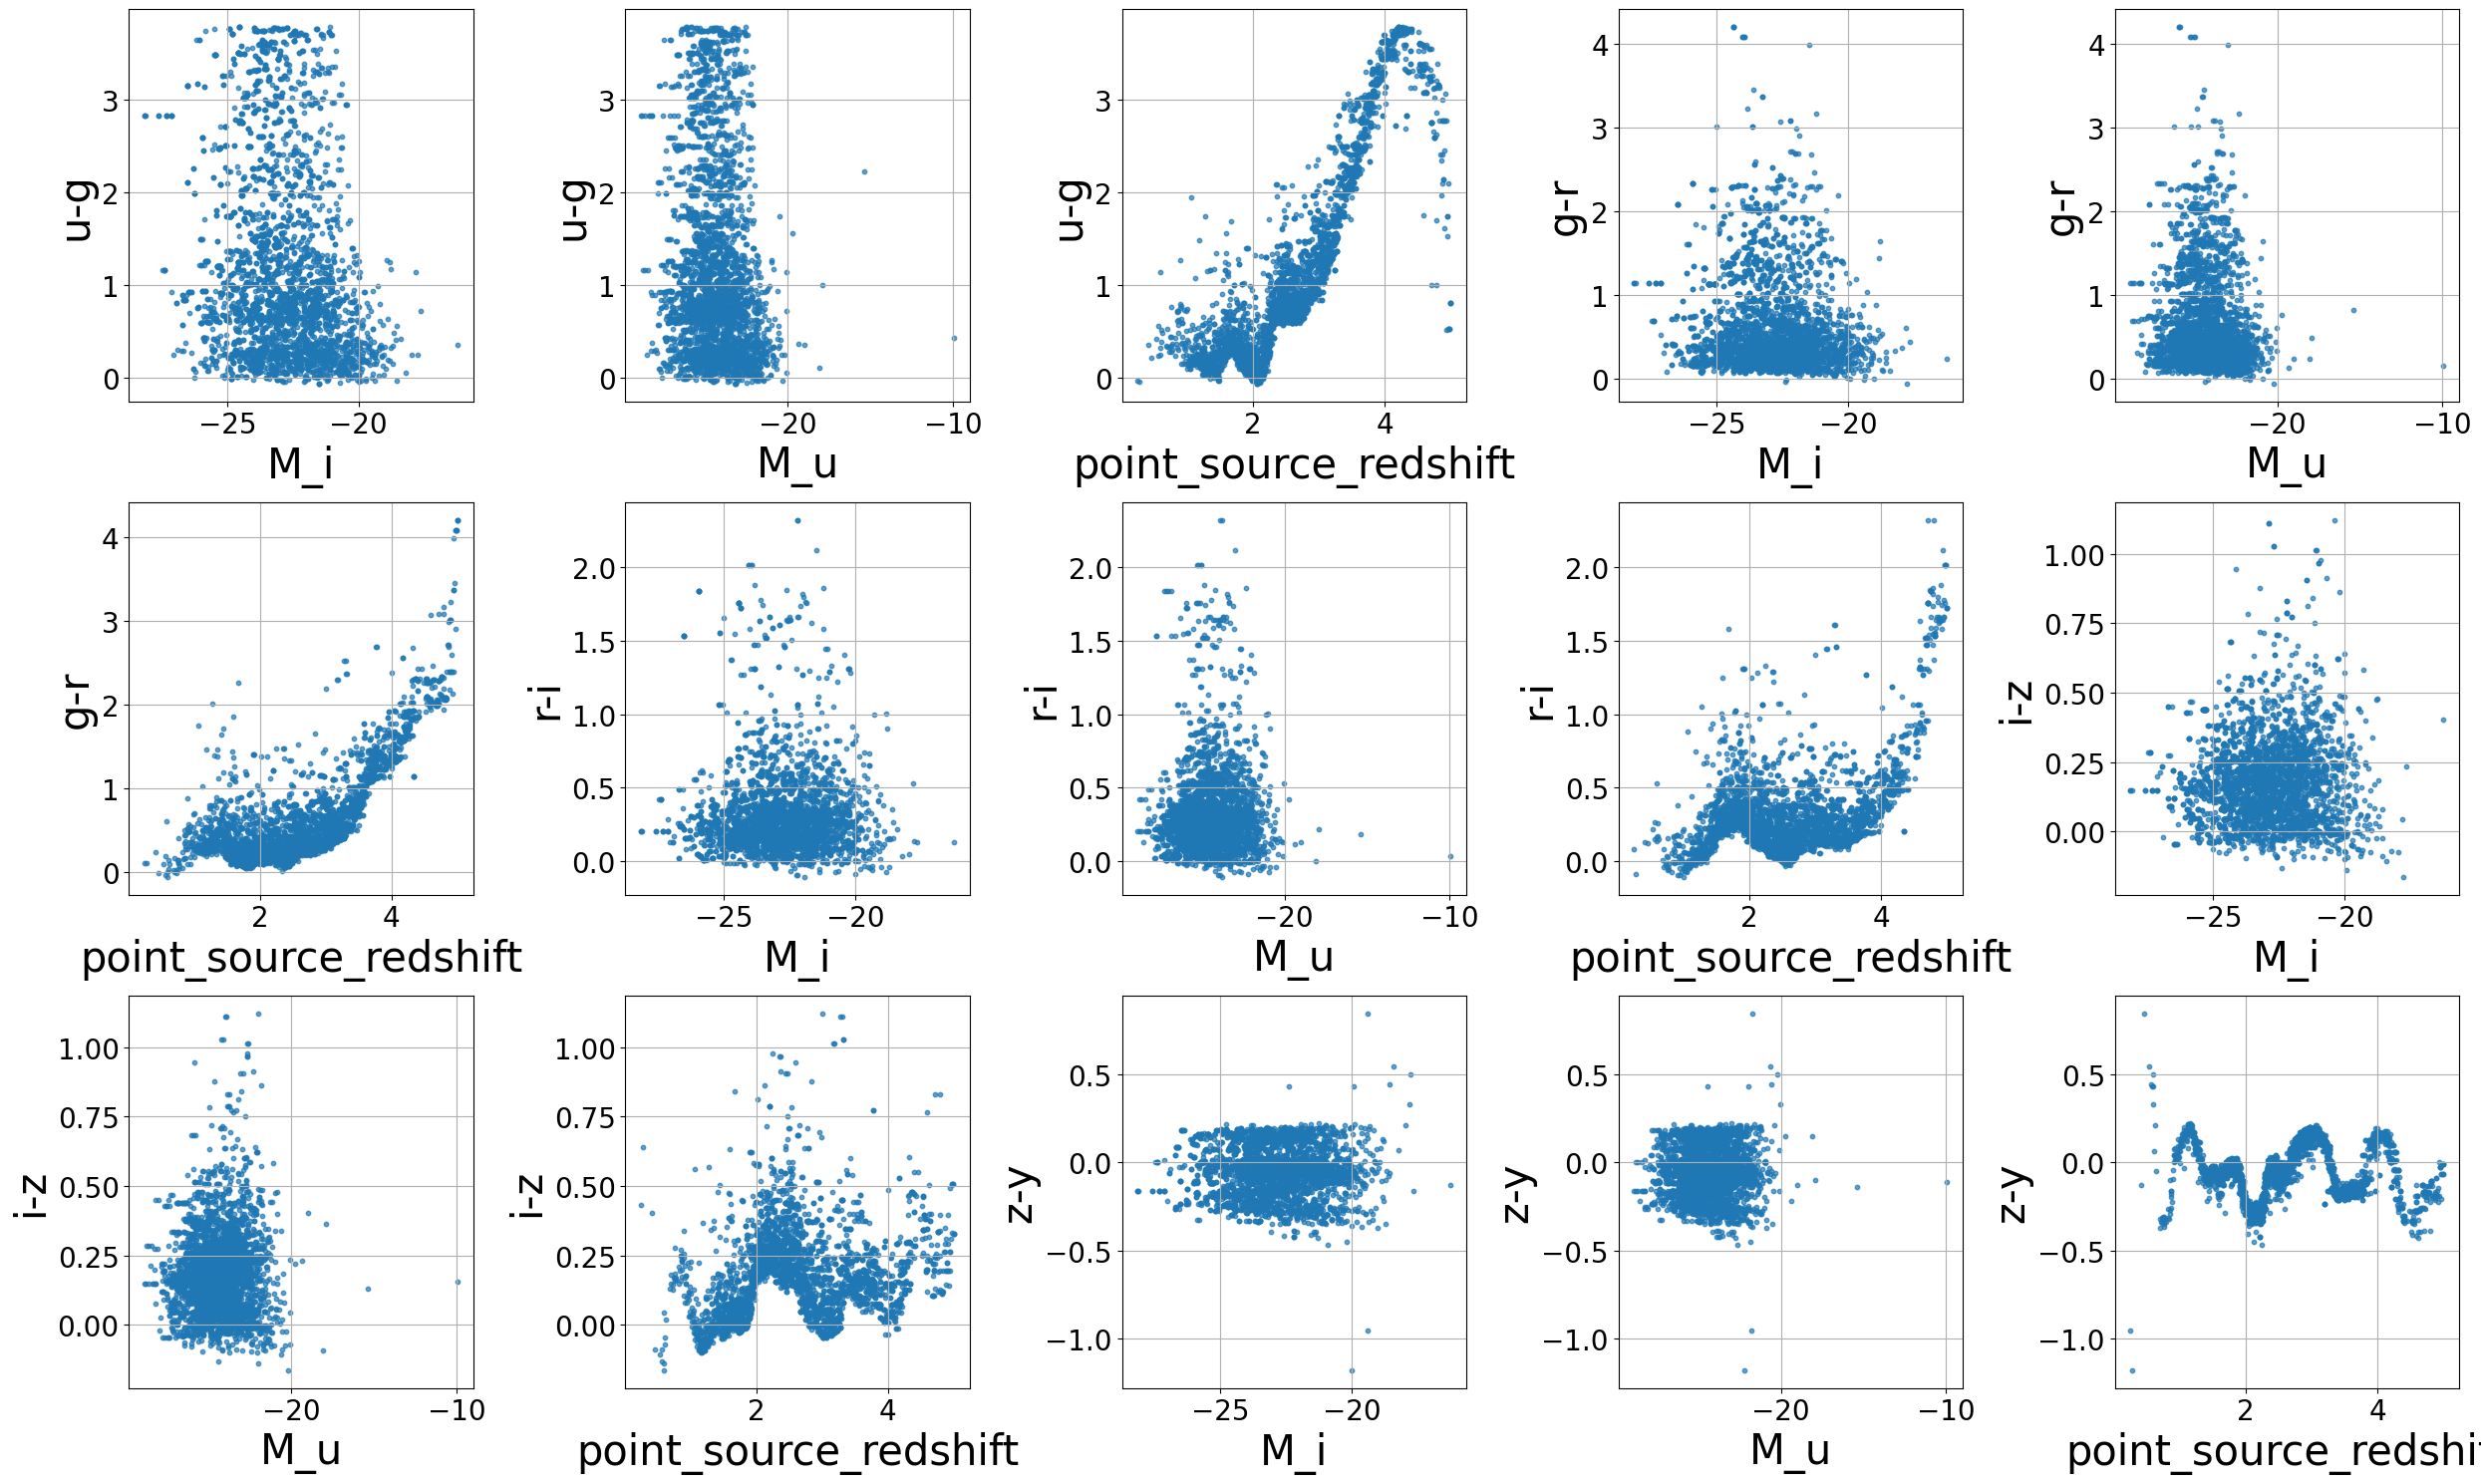

In [117]:
# Add colors to full_pop_df
full_pop_df2["u-g"] = full_pop_df2["ps_u_mag_true"] - full_pop_df2["ps_g_mag_true"]
full_pop_df2["g-r"] = full_pop_df2["ps_g_mag_true"] - full_pop_df2["ps_r_mag_true"]
full_pop_df2["r-i"] = full_pop_df2["ps_r_mag_true"] - full_pop_df2["ps_i_mag_true"]
full_pop_df2["i-z"] = full_pop_df2["ps_i_mag_true"] - full_pop_df2["ps_z_mag_true"]
full_pop_df2["z-y"] = full_pop_df2["ps_z_mag_true"] - full_pop_df2["ps_y_mag_true"]

# Plot colors vs M_i, M_u, z_src
fig, axes = plt.subplots(3, 5, figsize=(25, 15))
axes = axes.flatten()
colors = ["u-g", "g-r", "r-i", "i-z", "z-y"]
x_labels = ["M_i", "M_u", "point_source_redshift"]

for i, color in enumerate(colors):
    for j, x_label in enumerate(x_labels):
        ax = axes[i * 3 + j]
        ax.scatter(full_pop_df2[x_label], full_pop_df2[color], s=10, alpha=0.7)

        ax.set_xlabel(x_label, size=30)
        ax.set_ylabel(color, size=30)
        ax.tick_params(axis="x", labelsize=20)
        ax.tick_params(axis="y", labelsize=20)
        ax.grid(True)

fig.tight_layout()
plt.show()

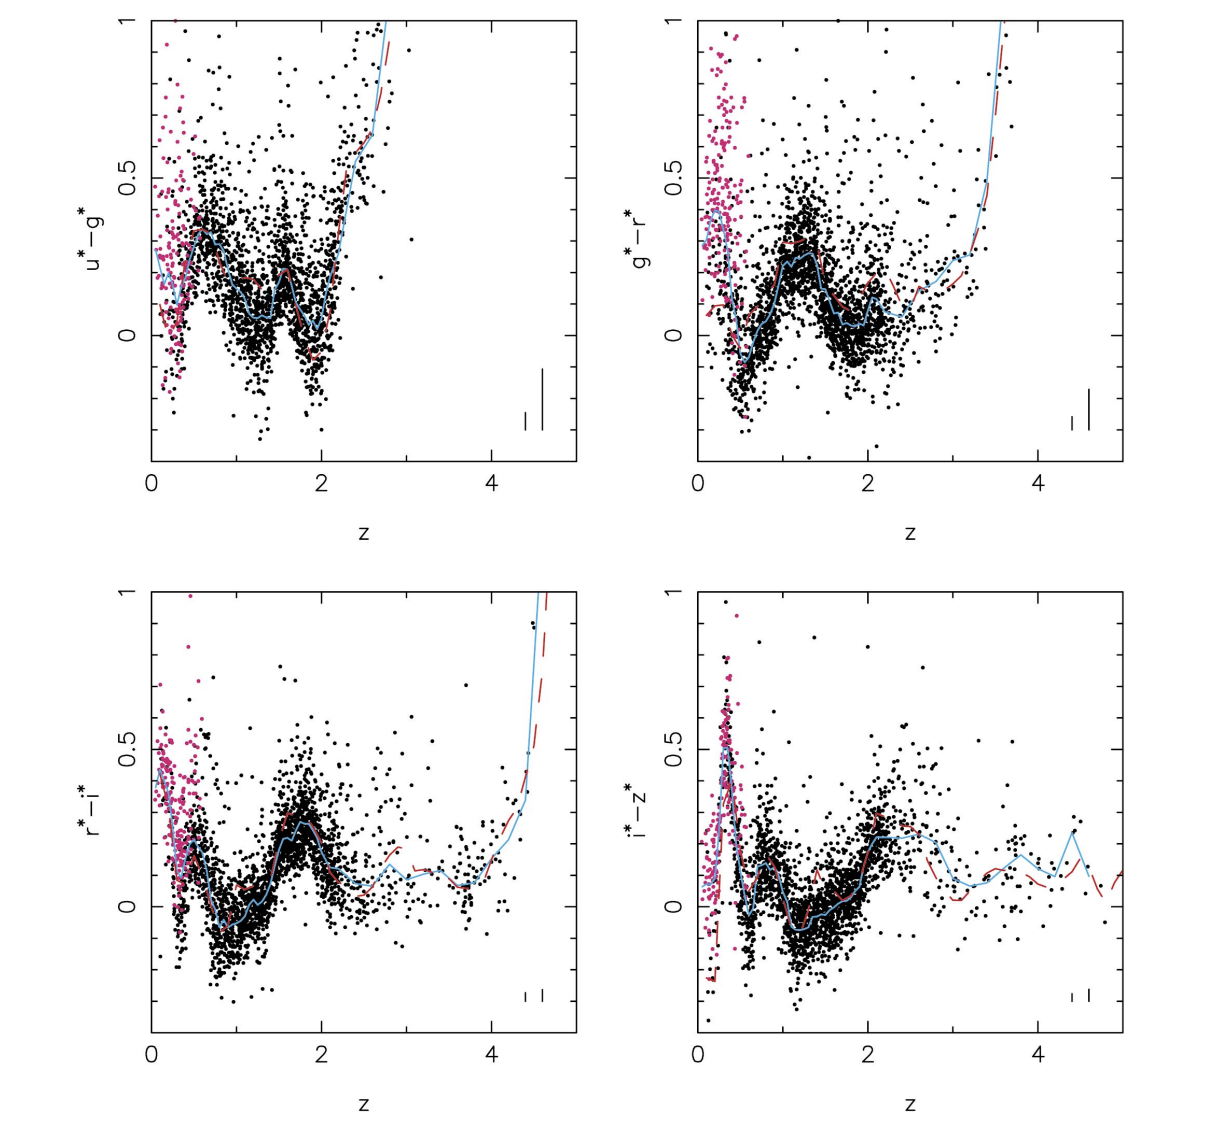

In [ ]:
# # Define redshift bins
# bins = [0, 3.3, 4, np.inf]
# labels = ["z < 3.3", "3.3 ≤ z ≤ 4", "z > 4"]
# color = "u-g"

# # Add a column for redshift bins
# color_cols = ["point_source_redshift", "M_i", "u-g", "g-r", "r-i", "i-z", "z-y"]
# post_offset = full_pop_df[color_cols]

# post_offset["z_bin"] = pd.cut(
#     post_offset["point_source_redshift"], bins=bins, labels=labels
# )

# # Plot absolute magnitude (i_mag) vs color (u-g) for each redshift bin
# fig, ax = plt.subplots(1, 3, figsize=(18, 6), sharey=True, sharex=True)

# for i, label in enumerate(labels):
#     agile_subset = agile_colors[
#         (agile_colors["redshift"] >= bins[i]) & (agile_colors["redshift"] < bins[i + 1])
#     ]
#     im1 = ax[i].scatter(
#         agile_subset["i_mag"],
#         agile_subset[color],
#         c=agile_subset["redshift"],
#         cmap="viridis",
#         alpha=0.7,
#         s=10,
#         label="AGILE",
#     )

#     # SLSim data
#     slsim_subset = post_offset[post_offset["z_bin"] == label]
#     ax[i].scatter(
#         slsim_subset["M_i"],
#         slsim_subset[color],
#         color="red",
#         alpha=0.7,
#         s=10,
#         label="SLSim",
#     )

#     ax[i].set_title(label, fontsize=14)
#     ax[i].set_xlabel("M_i", fontsize=12)
#     ax[i].grid(True)
#     # ax[i].set_xlim(-27, -19)
#     ax[i].legend()
#     ax[i].tick_params(axis="both", labelsize=14)
#     ax[i].title.set_fontsize(16)
#     ax[i].xaxis.label.set_fontsize(14)
#     ax[i].yaxis.label.set_fontsize(14)
#     ax[i].legend(fontsize=12)
#     fig.colorbar(im1, ax=ax[i])
# ax[0].set_ylabel(f"{color}", fontsize=12)
# fig.suptitle("Absolute Magnitude vs Color Binned by Redshift", fontsize=16)
# plt.tight_layout()
# plt.show()

KeyError: "['u-g', 'g-r', 'r-i', 'i-z', 'z-y'] not in index"

#### Microlensing parameters

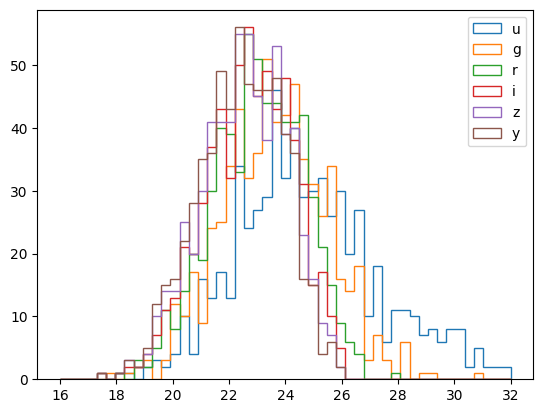

In [ ]:
bins = np.linspace(16, 32, 50)
for b in list("ugrizy"):
    plt.hist(full_pop_df[f"ps_{b}_mag_true"], bins=bins, histtype="step", label=b)
    plt.legend()

In [ ]:
for i in full_pop_df.index:
    lens = full_pop_df.loc[i, "lens_obj"]
    # sm = lens.deflector_stellar_mass()
    tm = lens.deflector_lensing_mass()
    tm2, s_in_ein = lens.deflector_stellar_mass_in_thetaE()
    full_pop_df.loc[i, "total_mass_from_lenstronomy"] = tm
    full_pop_df.loc[i, "total_mass_from_get_sigma"] = tm2
    full_pop_df.loc[i, "stellar_mass_in_einstein_radius"] = s_in_ein

/var/folders/97/kgg891cd1tg6h957n9nm8rkm0000gn/T/ipykernel_44729/2442504973.py:27: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


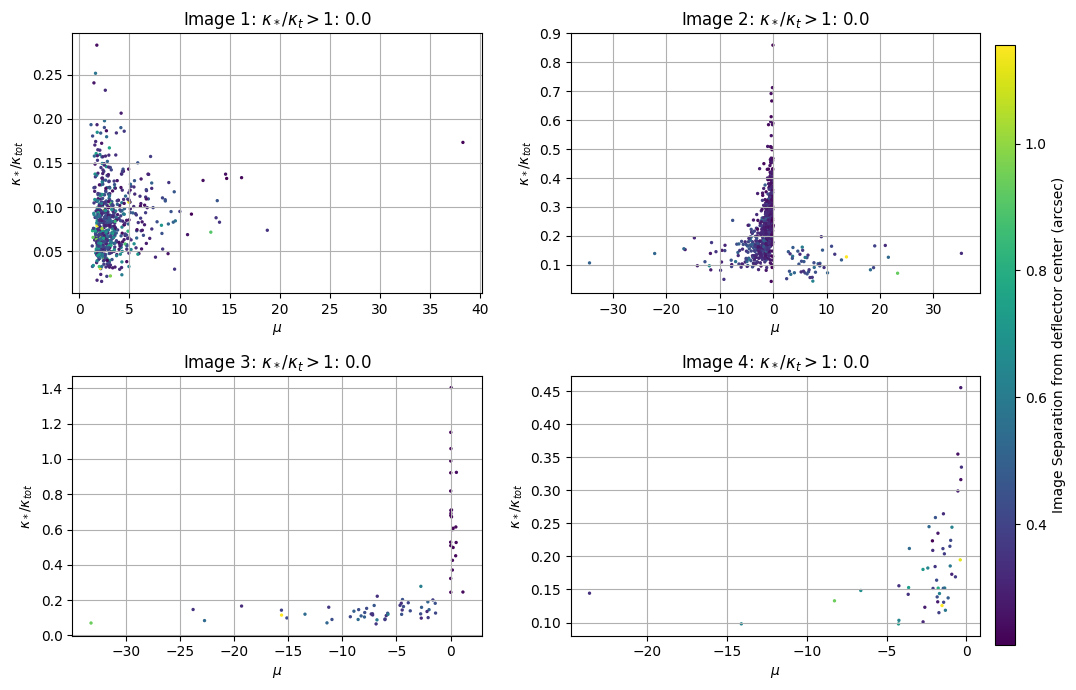

In [47]:
fig, axes = plt.subplots(2, 2, figsize=(10, 7))
axes = axes.flatten()

for i in range(4):
    kappa_ratio = (
        full_pop_df[f"micro_kappa_star_{i}"] / full_pop_df[f"micro_kappa_tot_{i}"]
    )
    magnification = full_pop_df[f"point_source_magnification_{i}"]
    x, y = np.array(
        full_pop_df[
            [
                f"point_source_light_i_ra_image_{i}",
                f"point_source_light_i_dec_image_{i}",
            ]
        ]
    ).T
    image_separations = np.sqrt(x**2 + y**2)

    sc = axes[i].scatter(
        magnification,
        kappa_ratio,
        s=2,
        c=image_separations,
        cmap="viridis",
    )
    axes[i].set_title(
        f"Image {i+1}: $\kappa_*/\kappa_t > 1$: {np.round(sum(kappa_ratio>1)/len(kappa_ratio),2)}"
    )
    axes[i].set_ylabel(r"$\kappa_* / \kappa_{tot}$")
    axes[i].set_xlabel("$\mu$")
    axes[i].grid(True)

# Add a single colorbar for all subplots
cbar = fig.colorbar(
    sc, ax=axes, orientation="vertical", shrink=1.0, aspect=30, pad=0.02
)
cbar.ax.set_position([1, 0, 0.02, 1])  # [left, bottom, width, height]
cbar.set_label("Image Separation from deflector center (arcsec)")

plt.tight_layout()
plt.show()

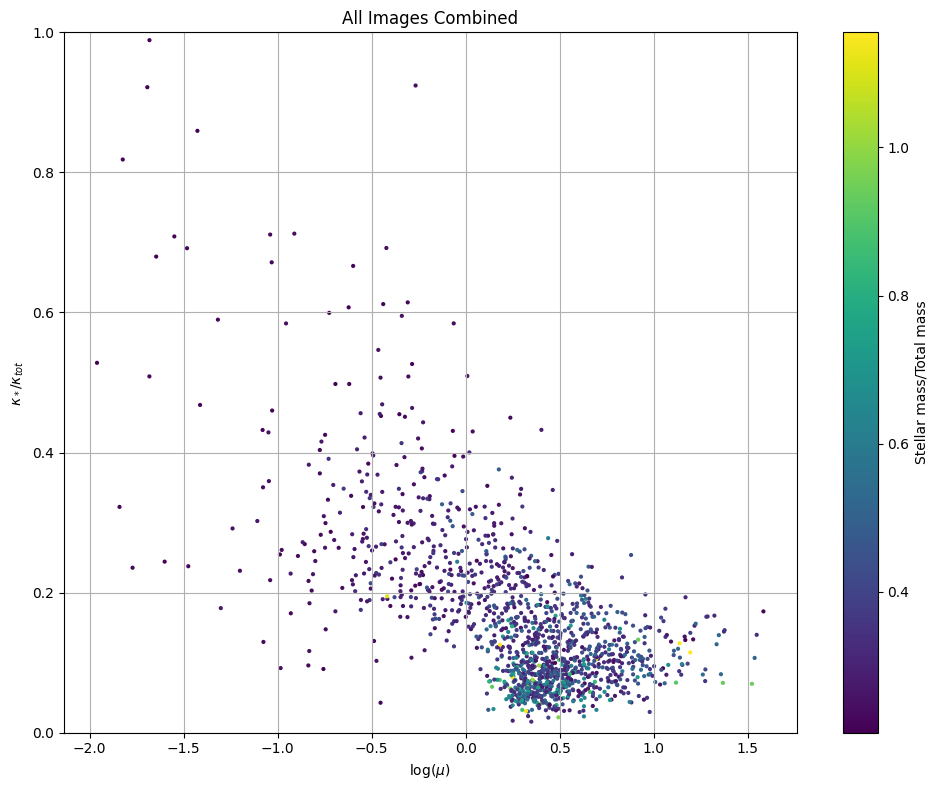

In [48]:
fig, ax = plt.subplots(figsize=(10, 8))
all_big_kappa = 0
for i in range(4):
    kappa_ratio = (
        full_pop_df[f"micro_kappa_star_{i}"] / full_pop_df[f"micro_kappa_tot_{i}"]
    )
    magnification = full_pop_df[f"point_source_magnification_{i}"]
    x, y = np.array(
        full_pop_df[
            [
                f"point_source_light_i_ra_image_{i}",
                f"point_source_light_i_dec_image_{i}",
            ]
        ]
    ).T
    image_separations = np.sqrt(x**2 + y**2)

    sc = ax.scatter(
        np.log10(np.abs(magnification)),
        kappa_ratio,
        s=4,
        c=image_separations,
        cmap="viridis",
    )
    all_big_kappa += sum(kappa_ratio > 1)

cbar = fig.colorbar(sc, ax=ax)
cbar.set_label("Stellar mass/Total mass")
ax.set_ylabel(r"$\kappa_* / \kappa_{tot}$")
ax.set_xlabel("$\log(\mu)$")
ax.set_title("All Images Combined")
ax.grid(True)
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

In [ ]:
all_big_kappa / len(full_pop_df)

In [ ]:
plt.scatter(
    np.log10(full_pop_df["total_mass_from_get_sigma"]),
    np.log10(full_pop_df["stellar_mass_in_einstein_radius"]),
)

# plt.scatter(full_pop_df['total_mass_from_lenstronomy'], full_pop_df['total_mass_from_get_sigma'])
# plt.scatter(full_pop_df['total_mass_from_lenstronomy'], full_pop_df['total_mass_from_lenstronomy'])
plt.xlabel("total mass in einstein radius")
plt.ylabel("stellar mass in einstein radius")

In [ ]:
full_pop_df.to_csv("time_delay_dataset.csv")

In [ ]:
mks = []
mkt = []
counter_bad = []
for i, lens in enumerate(quasar_lens_population):
    x, y = lens._point_source_image_positions(source_index=0)
    print()
    print("Image position in arcsec: ", np.sqrt(x**2 + y**2))

    kappa_star_images, kappa_tot_images, _, _ = (
        lens._microlensing_parameters_for_image_positions_single_source(
            band="i", source_index=0
        )
    )
    mks.append(kappa_star_images)
    mkt.append(kappa_tot_images)
    if np.sum(kappa_star_images > kappa_tot_images):
        counter_bad.append(i)

mks = np.concatenate(mks).flatten()
mkt = np.concatenate(mkt).flatten()


Image position in arcsec:  [1.48893653 1.40783352 1.36437442 1.19781201]
we are using 21.164204241854755 instead of [np.float64(38.973185557071936)].

Image position in arcsec:  [1.52925998 0.34901556]
we are using 1580.2736623755645 instead of [np.float64(3532.318831296538)].

Image position in arcsec:  [0.91472988 0.31517637]
we are using 73.17968714479898 instead of [np.float64(178.86034415015095)].

Image position in arcsec:  [0.7700796  0.38706845]
we are using 685.8073755767789 instead of [np.float64(1388.252824917957)].

Image position in arcsec:  [3.42053202 0.44459566]
we are using 60.58433509741735 instead of [np.float64(81.20227682932915)].

Image position in arcsec:  [1.33238329 0.81163344]
we are using 2260.6680624402966 instead of [np.float64(2940.3151383269646)].

Image position in arcsec:  [3.27414182 0.7625783 ]
we are using 158.9458757760511 instead of [np.float64(292.10637560620836)].

Image position in arcsec:  [1.30431572 0.77651345]
we are using 13.22585652784675

#### stellar_mass = min(deflector_stellar_mass, total_mass), n_sersic = 1

In [ ]:
# Select 100 random lenses from qlp
# random_lenses = random.sample(qlp, 5)
random_lenses_idx = counter_bad[:100]

# Create a 10x10 grid for the plots
fig, axes = plt.subplots(10, 10, figsize=(20, 20))
axes = axes.flatten()

# Loop through each lens and plot its profile
for i, ind in enumerate(random_lenses_idx):
    lens = quasar_lens_population[ind]
    r = np.logspace(-2, 1.2, 1000)  # Define the radius range
    M_enclosed, M_star_enclosed = lens.get_sigma(r)  # Get the mass profiles

    ax = axes[i]
    ax.loglog(r, M_enclosed, label="Total mass", color="blue")
    ax.loglog(r, M_star_enclosed, label="Stellar mass", color="orange")
    ax.axvline(
        lens.einstein_radius, color="red", linestyle="--", label="Einstein radius"
    )
    ax.set_title(f"Lens {i+1}", fontsize=8)
    ax.tick_params(axis="both", which="major", labelsize=6)
    ax.tick_params(axis="both", which="minor", labelsize=6)
    # Add a star at the images' distance from the center of the deflector
    x, y = lens.point_source_image_positions()[0]
    dist = np.sqrt(x**2 + y**2)
    for d in dist:
        rimg, mimg, msimg = (
            r[np.isclose(r, d, rtol=0.01)],
            M_enclosed[np.isclose(r, d, rtol=0.01)],
            M_star_enclosed[np.isclose(r, d, rtol=0.01)],
        )
        ax.loglog(rimg, mimg, color="blue", marker="*")
        ax.loglog(rimg, msimg, color="orange", marker="*")
    # ax.grid(True, which="both", linestyle="--", linewidth=0.5)
    ax.set_xlabel("Radius [arcsec]", fontsize=6)
    ax.set_ylabel("Mass (M<r) [M_sun]", fontsize=6)
    ax.legend(fontsize=6)

# Adjust layout
plt.tight_layout()
plt.show()

#### stellar_mass = min(deflector_stellar_mass, total_mass), n_sersic = 4

In [ ]:
# Select 100 random lenses from qlp
# random_lenses = random.sample(qlp, 5)
random_lenses_idx = counter_bad[:100]

# Create a 10x10 grid for the plots
fig, axes = plt.subplots(10, 10, figsize=(20, 20))
axes = axes.flatten()

# Loop through each lens and plot its profile
for i, ind in enumerate(random_lenses_idx):
    lens = quasar_lens_population[ind]
    r = np.logspace(-2, 1.2, 1000)  # Define the radius range
    M_enclosed, M_star_enclosed, tot_flux = lens.get_sigma(r)  # Get the mass profiles

    ax = axes[i]
    ax.loglog(r, M_enclosed, label="Total mass", color="blue")
    ax.loglog(r, M_star_enclosed, label="Stellar mass", color="orange")
    ax.axvline(
        lens.einstein_radius, color="red", linestyle="--", label="Einstein radius"
    )
    ax.axhline(tot_flux, color="green", ls="--", label="Total Flux")
    ax.set_title(f"Lens {i+1}", fontsize=8)
    ax.tick_params(axis="both", which="major", labelsize=6)
    ax.tick_params(axis="both", which="minor", labelsize=6)
    # Add a star at the images' distance from the center of the deflector
    x, y = lens.point_source_image_positions()[0]
    dist = np.sqrt(x**2 + y**2)
    for d in dist:
        rimg, mimg, msimg = (
            r[np.isclose(r, d, rtol=0.01)],
            M_enclosed[np.isclose(r, d, rtol=0.01)],
            M_star_enclosed[np.isclose(r, d, rtol=0.01)],
        )
        ax.loglog(rimg, mimg, color="blue", marker="*")
        ax.loglog(rimg, msimg, color="orange", marker="*")
    # ax.grid(True, which="both", linestyle="--", linewidth=0.5)
    ax.set_xlabel("Radius [arcsec]", fontsize=6)
    ax.set_ylabel("Mass (M<r) [M_sun]", fontsize=6)
    ax.legend(fontsize=6)

# Adjust layout
plt.tight_layout()
plt.show()

#### stellar-mass = deflector_stellar_mass, n_sersic = 4

In [ ]:
# Select 100 random lenses from qlp
# random_lenses = random.sample(qlp, 5)
random_lenses_idx = counter_bad[:100]

# Create a 10x10 grid for the plots
fig, axes = plt.subplots(10, 10, figsize=(20, 20))
axes = axes.flatten()

# Loop through each lens and plot its profile
for i, ind in enumerate(random_lenses_idx):
    lens = quasar_lens_population[ind]
    r = np.logspace(-2, 1.2, 1000)  # Define the radius range
    M_enclosed, M_star_enclosed = lens.get_sigma(r)  # Get the mass profiles

    ax = axes[i]
    ax.loglog(r, M_enclosed, label="Total mass", color="blue")
    ax.loglog(r, M_star_enclosed, label="Stellar mass", color="orange")
    ax.axvline(
        lens.einstein_radius, color="red", linestyle="--", label="Einstein radius"
    )
    # ax.axhline(lens.flux_in_theta_E, color='green', ls='--', label='Total Flux')
    ax.set_title(f"Lens {i+1}", fontsize=8)
    ax.tick_params(axis="both", which="major", labelsize=6)
    ax.tick_params(axis="both", which="minor", labelsize=6)
    # Add a star at the images' distance from the center of the deflector
    x, y = lens.point_source_image_positions()[0]
    dist = np.sqrt(x**2 + y**2)
    for d in dist:
        rimg, mimg, msimg = (
            r[np.isclose(r, d, rtol=0.01)],
            M_enclosed[np.isclose(r, d, rtol=0.01)],
            M_star_enclosed[np.isclose(r, d, rtol=0.01)],
        )
        ax.loglog(rimg, mimg, color="blue", marker="*")
        ax.loglog(rimg, msimg, color="orange", marker="*")
    # ax.grid(True, which="both", linestyle="--", linewidth=0.5)
    ax.set_xlabel("Radius [arcsec]", fontsize=6)
    ax.set_ylabel("Mass (M<r) [M_sun]", fontsize=6)
    ax.legend(fontsize=6)

# Adjust layout
plt.tight_layout()
plt.show()

#### stellar-mass = deflector_stellar_mass, n_sersic = 1

In [ ]:
# Select 100 random lenses from qlp
# random_lenses = random.sample(qlp, 5)
random_lenses_idx = counter_bad[:100]

# Create a 10x10 grid for the plots
fig, axes = plt.subplots(10, 10, figsize=(20, 20))
axes = axes.flatten()

# Loop through each lens and plot its profile
for i, ind in enumerate(random_lenses_idx):
    lens = quasar_lens_population[ind]
    r = np.logspace(-2, 1.2, 1000)  # Define the radius range
    M_enclosed, M_star_enclosed = lens.get_sigma(r)  # Get the mass profiles

    ax = axes[i]
    ax.loglog(r, M_enclosed, label="Total mass", color="blue")
    ax.loglog(r, M_star_enclosed, label="Stellar mass", color="orange")
    ax.axvline(
        lens.einstein_radius, color="red", linestyle="--", label="Einstein radius"
    )
    # ax.axhline(lens.flux_in_theta_E, color='green', ls='--', label='Total Flux')
    ax.set_title(f"Lens {i+1}", fontsize=8)
    ax.tick_params(axis="both", which="major", labelsize=6)
    ax.tick_params(axis="both", which="minor", labelsize=6)
    # Add a star at the images' distance from the center of the deflector
    x, y = lens.point_source_image_positions()[0]
    dist = np.sqrt(x**2 + y**2)
    for d in dist:
        rimg, mimg, msimg = (
            r[np.isclose(r, d, rtol=0.01)],
            M_enclosed[np.isclose(r, d, rtol=0.01)],
            M_star_enclosed[np.isclose(r, d, rtol=0.01)],
        )
        ax.loglog(rimg, mimg, color="blue", marker="*")
        ax.loglog(rimg, msimg, color="orange", marker="*")
    # ax.grid(True, which="both", linestyle="--", linewidth=0.5)
    ax.set_xlabel("Radius [arcsec]", fontsize=6)
    ax.set_ylabel("Mass (M<r) [M_sun]", fontsize=6)
    ax.legend(fontsize=6)

# Adjust layout
plt.tight_layout()
plt.show()

### Look at microlensing parameters

In [ ]:
lens._microlensing_parameters_for_image_positions_single_source(
    band="i", source_index=0
)

In [ ]:
len(counter_bad), len(quasar_lens_population), len(counter_bad) / len(
    quasar_lens_population
),
100 * len(counter_bad) / len(quasar_lens_population)

In [ ]:
image_separations = []
for lens in quasar_lens_population:
    x, y = lens.point_source_image_positions()[0]
    image_separations.extend(np.sqrt(x**2 + y**2))

image_separations = np.array(image_separations)

mask = np.bool(np.ones(len(image_separations)))
# mask = mkt<2.5

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
sc = ax[0].scatter(
    mkt[mask], mks[mask], c=image_separations[mask], s=20, cmap="viridis"
)
ax[0].set_xlabel("$\kappa_{tot}$")
ax[0].set_ylabel("$\kappa_*$")
ax[0].plot(mkt[mask], mkt[mask], ls="--", color="k")
cb = fig.colorbar(sc, ax=ax[0])
cb.set_label("Image Separation (arcsec)")

# Scatter plot for kappa_tot vs kappa_star / kappa_tot
sc = ax[1].scatter(
    mkt[mask], mks[mask] / mkt[mask], c=image_separations[mask], s=20, cmap="viridis"
)
ax[1].set_xlabel("$\kappa_{tot}$")
ax[1].set_ylabel("$\kappa_* / \kappa_{tot}$")
ax[1].axhline(1, ls="--", color="k")
cb = fig.colorbar(sc, ax=ax[1])
cb.set_label("Image Separation (arcsec)")

# Add fraction text
fraction = np.sum((mks[mask] / mkt[mask]) > 1) / len(mkt[mask])
ax[1].text(
    0.05,
    0.95,
    f"Fraction > 1: {fraction:.2%}",
    transform=ax[1].transAxes,
    verticalalignment="top",
    fontsize=10,
    bbox=dict(facecolor="white", alpha=0.8),
)

fig.suptitle("Kappa vs Kappa star for full sample (colored by max separation)")
plt.tight_layout()

In [ ]:
for i in range(4):
    bins = np.arange(0, 15, 0.5)
    full_pop_df[f"micro_kappa_tot_{i}"].hist(
        density=True, label=i, bins=bins, alpha=0.7
    )
plt.xlabel("$\kappa_{tot}$")
plt.ylabel("density")
plt.legend()

#### Look at quasar magnitudes and variable magnitudes

## Generate images

### Set the cadence of observation

In [ ]:
def get_random_ra_dec(N=1):
    ra_points = coord.Angle(np.random.uniform(low=0, high=360, size=N) * u.degree)
    ra_points = ra_points.wrap_at(180 * u.degree)
    # dec goes from -72 to +12
    lower = -70
    upper = 10
    p = (
        np.sin(np.random.uniform(low=lower, high=upper, size=N) * u.deg)
        - np.sin(lower * u.deg)
    ) / (np.sin(upper * u.deg) - np.sin(lower * u.deg))
    dec_points = coord.Angle(
        ((((np.arcsin(2 * p - 1).to(u.deg) + 90 * u.deg) / (180 * u.deg)) * 84) + lower)
        * u.deg
    )
    return ra_points, dec_points

### Cherry pick a few systems

#### Look at rubin_sim year on year outputs

In [ ]:
ra_points, dec_points = get_random_ra_dec(N=1)
rubin_df = get_rubin_cadence(ra_points, dec_points)

In [ ]:
rubin_df.columns

In [ ]:
# Convert observationStartMJD to years (assuming year 1 starts at MJD = 0)
rubin_df_binned = rubin_df.copy()
rubin_df_binned["year"] = rubin_df_binned["observationStartMJD"].apply(
    lambda mjd_list: np.floor(np.array(mjd_list) / 365.25) + 1
)

# Initialize a dictionary to store the results
results = {
    "year": [],
    "band": [],
    "skyBrightness_mean": [],
    "seeingFwhmEff_mean": [],
    "fiveSigmaDepth_mean": [],
    "skyBrightness_std": [],
    "seeingFwhmEff_std": [],
    "fiveSigmaDepth_std": [],
}

# Loop through each band and calculate the averages for each year
for band in rubin_df.index:
    df_band = pd.DataFrame(
        {
            "year": rubin_df_binned.loc[band, "year"],
            "skyBrightness": rubin_df.loc[band, "skyBrightness"],
            "seeingFwhmEff": rubin_df.loc[band, "seeingFwhmEff"],
            "fiveSigmaDepth": rubin_df.loc[band, "fiveSigmaDepth"],
        }
    )
    grouped_mean = df_band.groupby("year").mean()
    grouped_std = df_band.groupby("year").std()
    for year in grouped_mean.index:
        results["year"].append(year)
        results["band"].append(band)
        results["skyBrightness_mean"].append(grouped_mean.loc[year, "skyBrightness"])
        results["seeingFwhmEff_mean"].append(grouped_mean.loc[year, "seeingFwhmEff"])
        results["fiveSigmaDepth_mean"].append(grouped_mean.loc[year, "fiveSigmaDepth"])
        results["skyBrightness_std"].append(grouped_std.loc[year, "skyBrightness"])
        results["seeingFwhmEff_std"].append(grouped_std.loc[year, "seeingFwhmEff"])
        results["fiveSigmaDepth_std"].append(grouped_std.loc[year, "fiveSigmaDepth"])

# Convert results to a DataFrame
results_df = pd.DataFrame(results)

# Plot the results
fig, axes = plt.subplots(3, 1, figsize=(10, 15))
metrics = ["skyBrightness", "seeingFwhmEff", "fiveSigmaDepth"]
titles = ["Average Sky Brightness", "Average Seeing FWHM", "Average Five Sigma Depth"]

for i, metric in enumerate(metrics):
    ax = axes[i]
    for band in list("ugrizy"):
        subset = results_df[results_df["band"] == band]
        ax.errorbar(
            subset["year"],
            subset[metric + "_mean"],
            fmt="-o",
            yerr=subset[metric + "_std"] / np.sqrt(len(rubin_df.loc["u"])),
            label=f"{band}-band",
        )
    ax.set_title(titles[i], fontsize=14)
    ax.set_ylabel(metric, fontsize=12)
    ax.set_xticks(np.arange(1, 11))
    ax.set_xticklabels(np.arange(1, 11))

    ax.grid(True)
    ax.legend()
axes[-1].set_xlabel("Year", fontsize=12)
plt.tight_layout()
plt.show()

### Get a random lens from full_pop_df

In [ ]:
lens_class = np.random.choice(quasar_lens_population)


# Get a point source coordinate so that you can plot these image center in the plot.
def compute_magnitude_zeropoint(mag_zp_1s, exposure_time=30, gain=1):
    return mag_zp_1s + 2.5 * np.log10(exposure_time / gain)


bands = list("ugrizy")
mag_zps = np.array(
    [
        26.52,
        28.51,
        28.36,
        28.17,
        27.78,
        26.82,
    ]
)  # taken from https://smtn-002.lsst.io/
mag_zero_points_1_second = dict(zip(bands, mag_zps))  # mag

mag_zero_points_30_seconds = dict(
    zip(bands, compute_magnitude_zeropoint(mag_zps))
)  # mag
delta_pix = 0.2  # arcsec/pixel
num_pix = 33  # pixels
exp_time = 30  # s
pix_coord_list = [
    point_source_coordinate_properties(
        lens_class,
        band=i,
        mag_zero_point=mag_zero_points_30_seconds[i],
        delta_pix=delta_pix,
        num_pix=num_pix,
        transform_pix2angle=np.array([[0.2, 0], [0, 0.2]]),
    )
    for i in bands[1:]
]
pix_coord_dict = dict(zip(bands[1:], pix_coord_list))

### Light curves

In [ ]:
lsst_colors = {
    "u": "#0c71ff",
    "g": "#49be61",
    "r": "#c61c00",
    "i": "#ffc200",
    "z": "#f341a2",
    "y": "#5d0000",
}

In [ ]:
# Select 5 random lenses
# random_lenses = np.random.choice(full_pop_df['lens_obj'], size=5, replace=False)

# Loop through each lens, change RA and Dec, and plot the light curves
# for lens_class in random_lenses:
# Get random RA and Dec
new_ra, new_dec = get_random_ra_dec(N=1)
lens_class.ra_image = np.array([new_ra.deg])
lens_class.dec_image = np.array([new_dec.deg])

# Get Rubin cadence for the new RA and Dec
rubin_df = get_rubin_cadence(new_ra, new_dec)

observation_dates = rubin_df["observationStartMJD"]
time = np.arange(0, length_of_light_curve, 1)
image_number = lens_class.image_number
if isinstance(image_number, list):
    image_number = image_number[
        0
    ]  # taking the number of images from the first plane source

fig, ax = plt.subplots(1, image_number, figsize=(30, 7))
ax = ax.flatten()

for band in list("grizy"):
    time_sampled = np.array(
        observation_dates[band]
    )  # we're picking the dates that we expect to observe with Rubin
    # loop through the bands and plot the light curves
    for i in range(image_number):
        ax[i].plot(
            time,
            lens_class.point_source_magnitude(
                band=band, lensed=True, time=time, microlensing=False
            )[0][i],
            label=f"{band}-band, image-{i+1}",
            color=lsst_colors[band],
            alpha=0.2,
        )
        ax[i].scatter(
            time_sampled,
            lens_class.point_source_magnitude(
                band=band, lensed=True, time=time_sampled, microlensing=False
            )[0][i],
            marker="*",
            s=100,
            color=lsst_colors[band],
        )

ax[0].set_ylabel("Magnitude", fontsize=20)
fig.supxlabel("Time [Days]", fontsize=20)
for a in ax:
    a.invert_yaxis()
    a.legend()
fig.suptitle(
    f"Light curves for {lens_class.image_number} images of a multiply-imaged quasar",
    fontsize=30,
)
fig.tight_layout()
plt.show()

### Images

In [ ]:
transform_matrix = np.array([[delta_pix, 0], [0, delta_pix]])

# let's set up psf kernel for each exposure. Here we have taken the same psf that we
# extracted above. However, each exposure can have different psf kernel and user should
# provide corresponding psf kernel to each exposure.
psf_kernel_list = [None]
transform_matrix_list = [transform_matrix]

# psf_kernels_all = np.array([dp0["psf_kernel"][:10]])[0]

# let's set pixel to angle transform matrix. Here we have taken the same matrix for
# each exposure but user should provide corresponding transform matrix to each exposure.


# provide magnitude zero point for each exposures. Here we have taken the same magnitude
#  zero point for each exposure but user should provide the corresponding magnitude
# zero point for each exposure.
image_lens_series_all_bands = []
for band in list("grizy"):
    time_sampled = observation_dates["i"]
    # indices = np.linspace(0, len(time_sampled) - 1, 5).astype(int)
    # time_sampled = np.array([time_sampled[i] for i in indices])

    repeats = len(time_sampled)
    mag_list = [mag_zero_points_30_seconds[band]]
    psf_kernels_all = psf_kernel_list * repeats
    transform_matrix_all = transform_matrix_list * repeats
    mag_list = [mag_zero_points_30_seconds[band]]
    mag_zero_points_all = mag_list * repeats
    # mag_zero_points_all = np.array([dp0["zero_point"][:10]])[0]

    expo_list = [exp_time]
    exposure_time_all = expo_list * repeats
    image_lens_series_all = lens_image_series(
        lens_class=lens_class,
        band=band,
        mag_zero_point=mag_zero_points_all,
        num_pix=num_pix,
        psf_kernel=psf_kernels_all,
        transform_pix2angle=transform_matrix_all,
        exposure_time=exposure_time_all,
        std_gaussian_noise=bkg_noise(
            0.005, 30, np.array(rubin_df.loc["i", "skyBrightness"]), 0.2, 1
        ),
        t_obs=time_sampled,
        with_deflector=True,
        with_ps=True,
        with_source=True,
        add_noise=False,
    )
    image_lens_series_all_bands.append(image_lens_series_all)
    pix_coord = pix_coord_dict[band]["image_pix"]  # band r

    # plot_montage = create_image_montage_from_image_list(
    #     num_rows=1,
    #     num_cols=5,
    #     images=image_lens_series_all,
    #     time=time_sampled,
    #     image_center=pix_coord,
    # )
    # plot_montage.suptitle(f"{band}-band", y=1.01)

In [ ]:
time_sampled

In [ ]:
# Define the bands and the number of images to plot
bands = list("ugrizy")
num_images = 10
num_rows = 5

# Select 15 equally spaced time samples
time_sampled = np.linspace(0, length_of_light_curve, num_images, dtype=int)

# Create a figure for the plot
fig, axes = plt.subplots(num_rows, num_images, figsize=(20, 15))
# axes = axes.flatten()
bands = list("grizy")
# Loop through each band and plot the images
for i, band in enumerate(bands):  # Limit to the number of rows
    for j, time_idx in enumerate(time_sampled):
        # Generate the image for the given band and time
        image = image_lens_series_all_bands[i][j]

        # Plot the image
        ax = axes[i][j]
        ax.imshow(image, origin="lower", cmap="viridis")
        ax.set_title(f"{band}-band, t={time_sampled[j]}")
        ax.axis("off")

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

### plot bright/faint, high-z/low-z, low/high image separation lenses

In [ ]:
# Identify lenses based on the specified criteria
highest_i3 = full_pop_df.loc[full_pop_df["i3"].idxmax()]
lowest_i3 = full_pop_df.loc[full_pop_df["i3"].idxmin()]

full_pop_df["max_image_separation"] = full_pop_df["lens_obj"].apply(
    lambda lens: max(
        np.sqrt(np.sum(np.array(lens.point_source_image_positions()[0]) ** 2, axis=0))
    )
)
highest_max_sep = full_pop_df.loc[full_pop_df["max_image_separation"].idxmax()]
lowest_max_sep = full_pop_df.loc[full_pop_df["max_image_separation"].idxmin()]

highest_ps_i_mag_true = full_pop_df.loc[full_pop_df["ps_i_mag_true"].idxmax()]
lowest_ps_i_mag_true = full_pop_df.loc[full_pop_df["ps_i_mag_true"].idxmin()]

highest_deflector_light_i_mag = full_pop_df.loc[
    full_pop_df["deflector_light_i_magnitude"].idxmax()
]
lowest_deflector_light_i_mag = full_pop_df.loc[
    full_pop_df["deflector_light_i_magnitude"].idxmin()
]

# Combine all selected lenses
selected_lenses = [
    highest_i3,
    lowest_i3,
    highest_max_sep,
    lowest_max_sep,
    highest_ps_i_mag_true,
    lowest_ps_i_mag_true,
    highest_deflector_light_i_mag,
    lowest_deflector_light_i_mag,
]


# Function to plot light curves and create image strips
def plot_lens_system(lens_row, title):
    lens_class = lens_row["lens_obj"]
    new_ra, new_dec = get_random_ra_dec(N=1)
    lens_class.ra_image = np.array([new_ra.deg])
    lens_class.dec_image = np.array([new_dec.deg])

    rubin_df = get_rubin_cadence(new_ra, new_dec)
    observation_dates = rubin_df["observationStartMJD"]
    time = np.arange(0, length_of_light_curve, 1)
    image_number = lens_class.image_number
    if isinstance(image_number, list):
        image_number = image_number[0]

    # Plot light curves
    fig, ax = plt.subplots(1, image_number, figsize=(30, 7))
    ax = ax.flatten()
    for band in list("grizy"):
        time_sampled = np.array(observation_dates[band])
        for i in range(image_number):
            ax[i].plot(
                time,
                lens_class.point_source_magnitude(
                    band=band, lensed=True, time=time, microlensing=False
                )[0][i],
                label=f"{band}-band, image-{i+1}",
                color=lsst_colors[band],
                alpha=0.2,
            )
            ax[i].scatter(
                time_sampled,
                lens_class.point_source_magnitude(
                    band=band, lensed=True, time=time_sampled, microlensing=False
                )[0][i],
                marker="*",
                s=100,
                color=lsst_colors[band],
            )
    ax[0].set_ylabel("Magnitude", fontsize=20)
    fig.supxlabel("Time [Days]", fontsize=20)
    for a in ax:
        a.invert_yaxis()
        a.legend()
    fig.suptitle(f"Light curves for {title}", fontsize=30)
    fig.tight_layout()
    plt.show()

    # Create image strip
    bands = list("grizy")
    num_images = 10
    time_sampled = np.linspace(0, length_of_light_curve, num_images, dtype=int)
    repeats = len(time_sampled)
    mag_list = [mag_zero_points_30_seconds[band]]
    mag_zero_points_all = mag_list * repeats
    image_lens_series_all_bands = []
    for band in bands:
        image_lens_series_all = lens_image_series(
            lens_class=lens_class,
            band=band,
            mag_zero_point=mag_zero_points_all,
            num_pix=num_pix,
            psf_kernel=[None] * repeats,
            transform_pix2angle=[transform_matrix] * repeats,
            exposure_time=[exp_time] * repeats,
            std_gaussian_noise=bkg_noise(
                0.005, 30, np.array(rubin_df.loc[band, "skyBrightness"]), 0.2, 1
            ),
            t_obs=time_sampled,
            with_deflector=True,
            with_ps=True,
            with_source=True,
            add_noise=False,
        )
        image_lens_series_all_bands.append(image_lens_series_all)

    fig, axes = plt.subplots(len(bands), num_images, figsize=(20, 15))
    for i, band in enumerate(bands):
        images_in_this_band = image_lens_series_all_bands[i]
        for j, time_idx in enumerate(time_sampled):
            image = images_in_this_band[j]
            ax = axes[i][j]
            ax.imshow(
                image,
                origin="lower",
                cmap="viridis",
                vmin=0,
                vmax=np.percentile(images_in_this_band, 99),
            )
            # Add a box around the image in the specific band color
            rect = plt.Rectangle(
                (0, 0),
                image.shape[1] - 1,
                image.shape[0] - 1,
                linewidth=2,
                edgecolor=lsst_colors[band],
                facecolor="none",
            )
            ax.add_patch(rect)
            ax.set_title("t = " + str(np.round(time_idx)))
            ax.axis("off")
    plt.suptitle(f"Image strip for {title}", fontsize=20)
    plt.tight_layout()
    plt.show()


# Plot for each selected lens
titles = [
    "faintest i3",
    "brightest i3",
    "High Image Separation",
    "Low Image Separation",
    "faintest ps_i_mag_true",
    "brightest ps_i_mag_true",
    "faintest Deflector Light i Magnitude",
    "brightest Deflector Light i Magnitude",
]
for lens_row, title in zip(selected_lenses, titles):
    plot_lens_system(lens_row, title)

In [ ]:
len(full_pop_df[full_pop_df["num_ps_images"] == 4]) / len(full_pop_df)

In [ ]:
# Create a DataFrame with band, observation time, and array of image
bands = ["g", "r", "i", "z", "y"]
data = []
### make a big array with all the exposure in all the bands -- combine the bands
g_obs = dict(zip(observation_dates["g"], image_lens_series_all_bands[0]))
r_obs = dict(zip(observation_dates["r"], image_lens_series_all_bands[1]))
i_obs = dict(zip(observation_dates["i"], image_lens_series_all_bands[2]))
z_obs = dict(zip(observation_dates["z"], image_lens_series_all_bands[3]))
y_obs = dict(zip(observation_dates["y"], image_lens_series_all_bands[4]))

# Combine the observation times and images for each band
for band, obs_dict in zip(bands, [g_obs, r_obs, i_obs, z_obs, y_obs]):
    for obs_time, image_array in obs_dict.items():
        data.append({"band": band, "obs_time": obs_time, "image_array": image_array})

# Convert the list of dictionaries into a DataFrame
image_df = pd.DataFrame(data)

# Display the DataFrame
image_df.sort_values("obs_time", inplace=True)
os.makedirs("frames", exist_ok=True)
all_images = np.concatenate([image.flatten() for image in image_df["image_array"]])

# Divide the DataFrame based on bands
bands = image_df["band"].unique()

for band in bands[1:]:
    band_df = image_df[image_df["band"] == band]
    frames = []
    all_band_images = np.concatenate(
        [image.flatten() for image in band_df["image_array"]]
    )
    zmin, zmax = np.percentile(all_images, [0.5, 99.5])
    # Generate and save the frames for the current band
    for ind in band_df.index:
        # Calculate the stacked observations (mean) until the current index
        stacked_image = band_df.loc[:ind, "image_array"].mean(axis=0)
        current_image = band_df.loc[ind, "image_array"]
        difference_image = current_image - stacked_image

        # Create the plots
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))

        # Plot the stacked observations
        im1 = axes[0].imshow(
            stacked_image,
            vmin=zmin,
            vmax=zmax,
            norm="asinh",
            origin="lower",
            cmap="viridis",
        )
        axes[0].set_title("Coadd (template)")
        divider = make_axes_locatable(axes[0])
        # 5. Append a new axes for the colorbar
        # 'right' specifies the position, 'size' controls the width/height of the colorbar,
        # and 'pad' controls the spacing between the plot and the colorbar.
        cax = divider.append_axes("right", size="5%", pad=0.1)
        cbar = plt.colorbar(im1, cax=cax)

        # Plot the current image
        im2 = axes[1].imshow(
            current_image,
            vmin=zmin,
            vmax=zmax,
            norm="asinh",
            origin="lower",
            cmap="viridis",
        )
        axes[1].set_title("Exposure (science image)")
        divider = make_axes_locatable(axes[1])
        # 5. Append a new axes for the colorbar
        # 'right' specifies the position, 'size' controls the width/height of the colorbar,
        # and 'pad' controls the spacing between the plot and the colorbar.
        cax = divider.append_axes("right", size="5%", pad=0.1)
        cbar = plt.colorbar(im2, cax=cax)

        # Plot the difference image
        im3 = axes[2].imshow(
            (difference_image - np.mean(difference_image)) / np.std(difference_image),
            vmin=-5,
            vmax=5,
            origin="lower",
            cmap="coolwarm",
        )
        axes[2].set_title("Difference Image \n(exposure - coadd)")
        divider = make_axes_locatable(axes[2])
        # 5. Append a new axes for the colorbar
        # 'right' specifies the position, 'size' controls the width/height of the colorbar,
        # and 'pad' controls the spacing between the plot and the colorbar.
        cax = divider.append_axes("right", size="5%", pad=0.1)
        cbar = plt.colorbar(
            im3,
            cax=cax,
        )
        cbar.set_label("$\sigma$", rotation=90, labelpad=10)
        # Add a super title
        obs_time = np.round(band_df.loc[ind, "obs_time"], 2)
        fig.suptitle(f"Band {band}: Day {obs_time}", fontsize=16)
        fig.tight_layout()
        # Save the frame
        frame_path = f"frames/frame_{band}_{ind}.png"
        plt.savefig(frame_path)
        plt.close()
        frames.append(Image.open(frame_path))

    # Save the frames as a gif for the current band
    gif_path = f"{band}_band_observations.gif"
    frames[0].save(
        gif_path,
        save_all=True,
        append_images=frames[1:],
        duration=200,
        loop=0,
    )

    # Clean up the frames directory
    for frame in frames:
        os.remove(frame.filename)

os.rmdir("frames")